Step 1- collect the extended streaming history from the 4 json files. They cover listening history from 2016 to 2023 
The listening history is not homogeneusly distributed throgout hte years we will also look at that.


In [82]:
#woaaaaahh
#import libraries

import pandas as pd
import json as json
import os as os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests  as requests
from requests import get
from requests import post
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import time
import base64
import textwrap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
from scipy.stats import chi2_contingency




In [60]:
# List to store data from each file
data_list = []

# Replace 'path/to/json/files' with the actual path to your JSON files
json_files_path = ["C:/Users/Baran/Documents/GitHub/DataScienceProject/Data/SpotifyExtendedStreamingHistory/Streaming_History_Audio_2016-2021_0.json",
             "C:/Users/Baran/Documents/GitHub/DataScienceProject/Data/SpotifyExtendedStreamingHistory/Streaming_History_Audio_2021-2022_1.json",
             "C:/Users/Baran/Documents/GitHub/DataScienceProject/Data/SpotifyExtendedStreamingHistory/Streaming_History_Audio_2022-2023_2.json",
             "C:/Users/Baran/Documents/GitHub/DataScienceProject/Data/SpotifyExtendedStreamingHistory/Streaming_History_Audio_2023_3.json"]

# Iterate through each JSON file in the directory
for filename in json_files_path:
        with open(filename, 'r', encoding='utf-8') as file:
        # Load each line as a separate JSON object
            for line in file:
                data = json.loads(line)
                data_list.append(data)

# Create a Pandas DataFrame from the list of JSON data
df = pd.DataFrame(data_list)

# Display the DataFrame
combined_row = df.apply(lambda x: ','.join(x.astype(str)), axis=0)

# Create a new DataFrame with the combined row
combined_df = pd.DataFrame([combined_row.tolist()], columns=df.columns)

display(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 16880 entries, 0 to 16879
dtypes: object(16880)
memory usage: 132.0+ KB


None

In [61]:
# Create a new DataFrame with the combined row
melted_df = pd.melt(df)
melted_df = melted_df.drop(columns=['variable'])
melted_df = melted_df.dropna()
melted_df = melted_df.reset_index(drop=True)
melted_df['value'] = melted_df['value'].astype(str)


display(melted_df)
display(melted_df.info())

value
0      {'ts': '2016-03-19T20:15:16Z', 'username': 'ba...
1      {'ts': '2021-07-24T09:39:17Z', 'username': 'ba...
2      {'ts': '2022-06-30T06:00:17Z', 'username': 'ba...
3      {'ts': '2023-02-11T19:07:31Z', 'username': 'ba...
4      {'ts': '2016-03-19T20:15:54Z', 'username': 'ba...
...                                                  ...
65940  {'ts': '2023-02-11T19:02:35Z', 'username': 'ba...
65941  {'ts': '2023-02-11T19:02:35Z', 'username': 'ba...
65942  {'ts': '2023-02-11T19:02:44Z', 'username': 'ba...
65943  {'ts': '2023-02-11T19:07:26Z', 'username': 'ba...
65944  {'ts': '2023-02-11T19:07:30Z', 'username': 'ba...

[65945 rows x 1 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65945 entries, 0 to 65944
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   65945 non-null  object
dtypes: object(1)
memory usage: 515.3+ KB


None

In [62]:
# Define the column list
column_list = ["ts","username","platform","ms_played","conn_country","ip_addr_decrypted",\
   "user_agent_decrypted","master_metadata_track_name","master_metadata_album_artist_name",\
    "master_metadata_album_album_name","spotify_track_uri","episode_name","episode_show_name",\
    "spotify_episode_uri","reason_start","reason_end","shuffle","skipped",'"offline',\
    'offline_timestamp','incognito_mode']

# Define a custom parsing function
def parse_data(row):
    data_dict = eval(row) 
    return pd.Series([data_dict.get(col, None) for col in column_list])

# Apply the parsing function to create new columns
parsed_df = melted_df['value'].apply(parse_data)

# Concatenate the parsed DataFrame with the original melted DataFrame
result_df = pd.concat([melted_df, parsed_df], axis=1)

# Drop the old 'variable' and 'value' columns
result_df = result_df.drop(columns=['value'])

# Rename the new columns based on the column list
result_df.columns = column_list

display(result_df)
display(result_df.info())

ts     username                      platform  \
0      2016-03-19T20:15:16Z  baanozcan03  Windows 10 (10.0.10586; x64)   
1      2021-07-24T09:39:17Z  baanozcan03       iOS 14.4.2 (iPhone12,1)   
2      2022-06-30T06:00:17Z  baanozcan03         iOS 15.5 (iPhone12,1)   
3      2023-02-11T19:07:31Z  baanozcan03                           ios   
4      2016-03-19T20:15:54Z  baanozcan03  Windows 10 (10.0.10586; x64)   
...                     ...          ...                           ...   
65940  2023-02-11T19:02:35Z  baanozcan03                           ios   
65941  2023-02-11T19:02:35Z  baanozcan03                           ios   
65942  2023-02-11T19:02:44Z  baanozcan03                           ios   
65943  2023-02-11T19:07:26Z  baanozcan03                           ios   
65944  2023-02-11T19:07:30Z  baanozcan03                           ios   

       ms_played conn_country ip_addr_decrypted user_agent_decrypted  \
0         295502           TR     78.172.125.37              unknown   
1         181379           TR   212.253.204.122              unknown   
2           2645           TR       5.47.73.166              unknown   
3           1230           TR     37.154.245.49              unknown   
4          31880           TR     78.172.125.37              unknown   
...          ...          ...               ...                  ...   
65940        998           TR     37.154.245.49              unknown   
65941     133882           TR     37.154.245.49              unknown   
65942       8591           TR     37.154.245.49              unknown   
65943     282800           TR     37.154.245.49              unknown   
65944       2351           TR     37.154.245.49              unknown   

                         master_metadata_track_name  \
0                                             Hello   
1                        Kafamda Kentsel Dönüşümler   
2                                         Empty Bed   
3                                         Free Bird   
4      Cheerleader (Felix Jaehn Remix) - Radio Edit   
...                                             ...   
65940                                    Don't Stay   
65941                                    Down Under   
65942                                  Buried Alive   
65943                          Single Handed Sailor   
65944          Here Comes The Sun - Remastered 2009   

      master_metadata_album_artist_name   master_metadata_album_album_name  \
0                                 Adele                              Hello   
1                         İkiye On Kala         Kafamda Kentsel Dönüşümler   
2                              Motorama                               Alps   
3                        Lynyrd Skynyrd  Pronounced' Leh-'Nerd 'Skin-'Nerd   
4                                   OMI                        Cheerleader   
...                                 ...                                ...   
65940                       Linkin Park                            Meteora   
65941                       Men At Work                  Business As Usual   
65942                 Avenged Sevenfold                          Nightmare   
65943                      Dire Straits                         Communiqué   
65944                       The Beatles                         Abbey Road   

       ... episode_name episode_show_name spotify_episode_uri reason_start  \
0      ...         None              None                None     clickrow   
1      ...         None              None                None      playbtn   
2      ...         None              None                None       fwdbtn   
3      ...         None              None                None       fwdbtn   
4      ...         None              None                None     clickrow   
...    ...          ...               ...                 ...          ...   
65940  ...         None              None                None       fwdbtn   
65941  ...         None              None        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65945 entries, 0 to 65944
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ts                                 65945 non-null  object
 1   username                           65945 non-null  object
 2   platform                           65945 non-null  object
 3   ms_played                          65945 non-null  int64 
 4   conn_country                       65945 non-null  object
 5   ip_addr_decrypted                  64692 non-null  object
 6   user_agent_decrypted               64692 non-null  object
 7   master_metadata_track_name         64538 non-null  object
 8   master_metadata_album_artist_name  64538 non-null  object
 9   master_metadata_album_album_name   64538 non-null  object
 10  spotify_track_uri                  64538 non-null  object
 11  episode_name                       1392 non-null   object
 12  epis

None

In [63]:
#time to make columns a bit more pleaseant to look at

#convert ts to datetime format with utc +3 timezone
result_df['ts'] = pd.to_datetime(result_df['ts'], errors='coerce').dt.tz_convert('Europe/Istanbul')
result_df['ts'] = pd.to_datetime(result_df['ts'], errors='coerce')

#cut off the rows that are before 2021, irrelevant data
result_df = result_df[result_df['ts'].dt.year > 2020]

#show the null values
nan_counts = result_df.isna().sum()
print(nan_counts)
display(result_df)

ts                                       0
username                                 0
platform                                 0
ms_played                                0
conn_country                             0
ip_addr_decrypted                        0
user_agent_decrypted                     0
master_metadata_track_name             676
master_metadata_album_artist_name      676
master_metadata_album_album_name       676
spotify_track_uri                      676
episode_name                         51578
episode_show_name                    51578
spotify_episode_uri                  51578
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                              28315
"offline                             52254
offline_timestamp                        0
incognito_mode                           0
dtype: int64


ts     username                 platform  \
1     2021-07-24 12:39:17+03:00  baanozcan03  iOS 14.4.2 (iPhone12,1)   
2     2022-06-30 09:00:17+03:00  baanozcan03    iOS 15.5 (iPhone12,1)   
3     2023-02-11 22:07:31+03:00  baanozcan03                      ios   
5     2021-07-24 12:40:09+03:00  baanozcan03  iOS 14.4.2 (iPhone12,1)   
6     2022-06-30 09:04:39+03:00  baanozcan03    iOS 15.5 (iPhone12,1)   
...                         ...          ...                      ...   
65940 2023-02-11 22:02:35+03:00  baanozcan03                      ios   
65941 2023-02-11 22:02:35+03:00  baanozcan03                      ios   
65942 2023-02-11 22:02:44+03:00  baanozcan03                      ios   
65943 2023-02-11 22:07:26+03:00  baanozcan03                      ios   
65944 2023-02-11 22:07:30+03:00  baanozcan03                      ios   

       ms_played conn_country ip_addr_decrypted user_agent_decrypted  \
1         181379           TR   212.253.204.122              unknown   
2           2645           TR       5.47.73.166              unknown   
3           1230           TR     37.154.245.49              unknown   
5           4096           TR   212.253.204.122              unknown   
6         232362           TR       5.47.73.166              unknown   
...          ...          ...               ...                  ...   
65940        998           TR     37.154.245.49              unknown   
65941     133882           TR     37.154.245.49              unknown   
65942       8591           TR     37.154.245.49              unknown   
65943     282800           TR     37.154.245.49              unknown   
65944       2351           TR     37.154.245.49              unknown   

                     master_metadata_track_name  \
1                    Kafamda Kentsel Dönüşümler   
2                                     Empty Bed   
3                                     Free Bird   
5                    Kafamda Kentsel Dönüşümler   
6      Instant Crush (feat. Julian Casablancas)   
...                                         ...   
65940                                Don't Stay   
65941                                Down Under   
65942                              Buried Alive   
65943                      Single Handed Sailor   
65944      Here Comes The Sun - Remastered 2009   

      master_metadata_album_artist_name   master_metadata_album_album_name  \
1                         İkiye On Kala         Kafamda Kentsel Dönüşümler   
2                              Motorama                               Alps   
3                        Lynyrd Skynyrd  Pronounced' Leh-'Nerd 'Skin-'Nerd   
5                         İkiye On Kala         Kafamda Kentsel Dönüşümler   
6                             Daft Punk             Random Access Memories   
...                                 ...                                ...   
65940                       Linkin Park                            Meteora   
65941                       Men At Work                  Business As Usual   
65942                 Avenged Sevenfold                          Nightmare   
65943                      Dire Straits                         Communiqué   
65944                       The Beatles                         Abbey Road   

       ... episode_name episode_show_name spotify_episode_uri reason_start  \
1      ...         None              None                None      playbtn   
2      ...         None              None                None       fwdbtn   
3      ...         None              None                None       fwdbtn   
5      ...         None              None                None    trackdone   
6      ...         None              None                None       fwdbtn   
...    ...          ...               ...                 ...          ...   
65940  ...         None              None                None       fwdbtn   
65941  ...         None              None                None    trackdone   
65942  ...         None            

In [64]:
#Seperate podcasts and music
podcast_df = result_df[result_df['episode_name'].notna()]
music_df = result_df[result_df['episode_name'].isna()]
podcast_df = podcast_df.sort_values(by='ts')
music_df = music_df.sort_values(by='ts')

#drop rows that dont have corresponding URI and show the dropped row count
podcast_df = podcast_df.dropna(subset=['spotify_episode_uri'])
music_df = music_df.dropna(subset=['spotify_track_uri'])



##lets conver the ms_played to seconds with 2 decimal places
podcast_df['ms_played'] = podcast_df['ms_played']/1000
podcast_df['ms_played'] = podcast_df['ms_played'].round(2)
music_df['ms_played'] = music_df['ms_played']/1000
music_df['ms_played'] = music_df['ms_played'].round(2)
#rename it to seconds_played
podcast_df = podcast_df.rename(columns={'ms_played': 'seconds_played'})
music_df = music_df.rename(columns={'ms_played': 'seconds_played'})


# Drop columns where all values are NaN
podcast_df = podcast_df.dropna(axis=1, how='all')
music_df = music_df.dropna(axis=1, how='all')


##lets create a season column 
# Define a function to determine the season
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Create a new 'season' column based on the 'ts' column
podcast_df['season'] = podcast_df['ts'].dt.month.apply(get_season)
music_df['season'] = music_df['ts'].dt.month.apply(get_season)

In [65]:
##Using API to get the song features

'''
#time to get song IDs
song_IDs = music_df['spotify_track_uri'].str.split(':').str[-1].unique().tolist()
print(song_IDs)

backup_song_IDs = song_IDs.copy()

client_id = ''
client_secret = ''


# Define a function to get the token
def get_token():
    authotization_str = client_id + ':' + client_secret
    authotization_bytes = authotization_str.encode('utf-8')
    base64_encoded = str(base64.b64encode(authotization_bytes), 'utf-8')

    url = 'https://accounts.spotify.com/api/token'
    headers = {'Authorization': 'Basic ' + base64_encoded, 'Content-Type': 'application/x-www-form-urlencoded'}
    dat = {'grant_type': 'client_credentials'}
    req = post(url, headers=headers, data=data)
    json_result = json.loads(req.content)
    token = json_result['access_token']
    return token

# Define a function to get the track features
auth_header = {'Authorization': 'Bearer ' + get_token()}
print(auth_header)
def get_track_features(track_id, auth_header):
    url = 'https://api.spotify.com/v1/audio-features/' + track_id
    req = get(url, headers=auth_header)
    json_result = json.loads(req.content)
    return json_result

# Replace 'your_results' with the desired base file name
base_file_name = 'my_results'

# Set the chunk size
chunk_size = 500

# Calculate the number of chunks
num_chunks = (len(song_IDs) + chunk_size - 1) // chunk_size

# Iterate through each chunk
for chunk_number in range(10,num_chunks):
    # Determine the start and end indices for the current chunk
    start_index = chunk_number * chunk_size
    end_index = (chunk_number + 1) * chunk_size

    # Get the track IDs for the current chunk
    current_chunk_ids = song_IDs[start_index:end_index]

    # Create the file name for the current chunk
    file_name = f'{base_file_name}_chunk_{chunk_number}.txt'
    
   
    # Open the file in write mode ('w')
    with open(file_name, 'w') as file:
        # Iterate through each response and write it to the file
        for id in current_chunk_ids:
            print(current_chunk_ids.index(id))
            time.sleep(0.4)
            response = get_track_features(id, auth_header)
            print(response)
            file.write(str(response) + '\n')  # Adjust this based on your data format
'''

"\n#time to get song IDs\nsong_IDs = music_df['spotify_track_uri'].str.split(':').str[-1].unique().tolist()\nprint(song_IDs)\n\nbackup_song_IDs = song_IDs.copy()\n\nclient_id = ''\nclient_secret = ''\n\n\n\ndef get_token():\n    authotization_str = client_id + ':' + client_secret\n    authotization_bytes = authotization_str.encode('utf-8')\n    base64_encoded = str(base64.b64encode(authotization_bytes), 'utf-8')\n\n    url = 'https://accounts.spotify.com/api/token'\n    headers = {'Authorization': 'Basic ' + base64_encoded, 'Content-Type': 'application/x-www-form-urlencoded'}\n    dat = {'grant_type': 'client_credentials'}\n    req = post(url, headers=headers, data=data)\n    json_result = json.loads(req.content)\n    token = json_result['access_token']\n    return token\n\nauth_header = {'Authorization': 'Bearer ' + get_token()}\nprint(auth_header)\n\n\ndef get_track_features(track_id, auth_header):\n    url = 'https://api.spotify.com/v1/audio-features/' + track_id\n    req = get(url,

In [66]:
# Replace 'CS210Project' with your actual project folder
project_folder = 'C:/Users/Baran/Documents/GitHub/DataScienceProject/Data'

# Specify the base file name
base_file_name = 'my_results_chunk_'

# Specify the file extension
file_extension = 'txt'
combined_list  = []

# Iterate over chunk numbers from 0 to 10
for chunk_number in range(11):  # This will include 0 to 10
    # Create the file name for the current chunk
    file_name = f'{base_file_name}{chunk_number}.{file_extension}'

    # Create the complete file path using os.path.join
    file_path = os.path.join(project_folder, file_name)
    file_path = file_path.replace('\\', '/')  # Replace backslashes with forward slashes

    # Read the text file line by line, parse each line as JSON, and append to DataFrame
    with open(file_path, 'r') as file:
        for line in file:
            combined_list.append(line)

# Your list of column names
column_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']

# Convert the list of strings to a pandas DataFrame
track_properties_df = pd.DataFrame([eval(line) for line in combined_list], columns=column_list)

# Display the DataFrame
display(track_properties_df)

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.471   0.431    5    -6.129     0       0.0342      0.329000   
1            0.827   0.576    4    -7.774     1       0.0372      0.184000   
2            0.540   0.766    4    -5.148     0       0.0700      0.000248   
3            0.702   0.770    9    -5.416     0       0.0482      0.124000   
4            0.593   0.748    0    -3.784     0       0.0461      0.151000   
...            ...     ...  ...       ...   ...          ...           ...   
5470         0.374   0.528    7   -14.547     1       0.1900      0.104000   
5471         0.946   0.572    9    -6.688     1       0.1330      0.006610   
5472         0.675   0.322    6   -12.126     0       0.1900      0.893000   
5473         0.455   0.758    0   -11.361     1       0.0454      0.223000   
5474         0.545   0.467    8   -10.862     1       0.0305      0.491000   

      instrumentalness  liveness  valence    tempo            type  \
0             0.000000    0.0854    0.289  157.980  audio_features   
1             0.029000    0.0656    0.410  118.040  audio_features   
2             0.000000    0.6410    0.176   98.932  audio_features   
3             0.000000    0.1030    0.593  107.951  audio_features   
4             0.000000    0.3010    0.468  100.007  audio_features   
...                ...       ...      ...      ...             ...   
5470          0.168000    0.1180    0.410   82.037  audio_features   
5471          0.000009    0.0711    0.297  124.965  audio_features   
5472          0.000000    0.1630    0.395   79.059  audio_features   
5473          0.000003    0.0986    0.540  141.304  audio_features   
5474          0.175000    0.0805    0.444  113.713  audio_features   

                          id                                   uri  \
0     1MDoll6jK4rrk2BcFRP5i7  spotify:track:1MDoll6jK4rrk2BcFRP5i7   
1     6fQcqEcXfnY0L6VwS0c3gT  spotify:track:6fQcqEcXfnY0L6VwS0c3gT   
2     5NUlOzzMdoIABFTnhizCQa  spotify:track:5NUlOzzMdoIABFTnhizCQa   
3     6RsWqX8zABZLhZydXxEFOm  spotify:track:6RsWqX8zABZLhZydXxEFOm   
4     0XXLwO7YHHTAK3OJkWQ37b  spotify:track:0XXLwO7YHHTAK3OJkWQ37b   
...                      ...                                   ...   
5470  1rOPLMaQP8yDdh1fPLIyXz  spotify:track:1rOPLMaQP8yDdh1fPLIyXz   
5471  6cOk7Ry9kZmnNAzVscxwnw  spotify:track:6cOk7Ry9kZmnNAzVscxwnw   
5472  7pxVwm2jd4LZyT68E78123  spotify:track:7pxVwm2jd4LZyT68E78123   
5473  2APxH5XbOLDTmW9X5yi6Hw  spotify:track:2APxH5XbOLDTmW9X5yi6Hw   
5474  36vTL8WP4ZoD1bbUaW0V3E  spotify:track:36vTL8WP4ZoD1bbUaW0V3E   

                                             track_href  \
0     https://api.spotify.com/v1/tracks/1MDoll6jK4rr...   
1     https://api.spotify.com/v1/tracks/6fQcqEcXfnY0...   
2     https://api.spotify.com/v1/tracks/5NUlOzzMdoIA...   
3     https://api.spotify.com/v1/tracks/6RsWqX8zABZL...   
4     https://api.spotify.com/v1/tracks/0XXLwO7YHHTA...   
...                                                 ...   
5470  https://api.spotify.com/v1/tracks/1rOPLMaQP8yD...   
5471  https://api.spotify.com/v1/tracks/6cOk7Ry9kZmn...   
5472  https://api.spotify.com/v1/tracks/7pxVwm2jd4LZ...   
5473  https://api.spotify.com/v1/tracks/2APxH5XbOLDT...   
5474  https://api.spotify.com/v1/tracks/36vTL8WP4ZoD...   

                                           analysis_url  duration_ms  \
0     https://api.spotify.com/v1/audio-analysis/1MDo...       295502   
1     https://api.spotify.com/v1/audio-analysis/6fQc...       180021   
2     https://api.spotify.com/v1/audio-analysis/5NUl...       224400   
3     https://api.spotify.com/v1/audio-analysis/6RsW...       213520   
4     https://api.spotify.com/v1/audio-analysis/0XXL...       219987   
...                                                 ...          ...   
5470  https://api.spotify.com/v1/audio-analysis/1rOP...       224211   
5471  https://api.spotify.com/v1/audio-analysis/6cOk...       243833   
5472  https://api.spotify.com/

In [67]:
#lest merge the two dataframes of music and track properties if the track uri matches
# Sample DataFrames

# Merge the DataFrames if the 'uri' columns match
music_df = music_df.rename(columns={'spotify_track_uri': 'uri'})
merged_df = pd.merge(music_df, track_properties_df, on='uri', how='left')


#display the first row of the merged dataframe
#all the columns should be printed in a different output
merged_df.rename(columns={'master_metadata_track_name': 'track_name', 'master_metadata_album_artist_name': 'artist_name', 'master_metadata_album_album_name': 'album_name'}, inplace=True)
#change duration_ms to seconds
merged_df['duration_ms'] = merged_df['duration_ms']/1000
merged_df['duration_ms'] = merged_df['duration_ms'].round(2)
merged_df.rename(columns={'duration_ms': 'duration_s'}, inplace=True)
display(merged_df.columns)


#clear the trackname column of any punctuation
merged_df['track_name'] = merged_df['track_name'].str.replace('[^\w\s]','')
#delete the word remastered from the track name
merged_df['track_name'] = merged_df['track_name'].str.replace('Remastered','')
merged_df['track_name'] = merged_df['track_name'].str.replace('remastered','')
merged_df['track_name'] = merged_df['track_name'].str.replace('Remaster','')
merged_df['track_name'] = merged_df['track_name'].str.replace('remaster','')
merged_df['track_name'] = merged_df['track_name'].str.replace('Remix','')
merged_df['track_name'] = merged_df['track_name'].str.replace('remix','')
merged_df['track_name'] = merged_df['track_name'].str.replace('(',' ')
merged_df['track_name'] = merged_df['track_name'].str.replace(')',' ')
merged_df['track_name'] = merged_df['track_name'].str.replace(' - ',' ')
merged_df['track_name'] = merged_df['track_name'].str.replace('  ',' ')
#delete any indication of a year in the track name
merged_df['track_name'] = merged_df['track_name'].str.replace(' 19\d{2}','')
merged_df['track_name'] = merged_df['track_name'].str.replace(' 20\d{2}','')

<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Baran\AppData\Local\Temp\ipykernel_5012\3135490500.py:20: SyntaxWarning: invalid escape sequence '\w'
  merged_df['track_name'] = merged_df['track_name'].str.replace('[^\w\s]','')
C:\Users\Baran\AppData\Local\Temp\ipykernel_5012\3135490500.py:33: SyntaxWarning: invalid escape sequence '\d'
  merged_df['track_name'] = merged_df['track_name'].str.replace(' 19\d{2}','')
C:\Users\Baran\AppData\Local\Temp\ipykernel_5012\3135490500.py:34: SyntaxWarning: invalid escape sequence '\d'
  merged_df['track_name'] = merged_df['track_name'].str.replace(' 20\d{2}','')


Index(['ts', 'username', 'platform', 'seconds_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted', 'track_name',
       'artist_name', 'album_name', 'uri', 'reason_start', 'reason_end',
       'shuffle', 'skipped', 'offline_timestamp', 'incognito_mode', 'season',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'track_href', 'analysis_url', 'duration_s',
       'time_signature'],
      dtype='object')

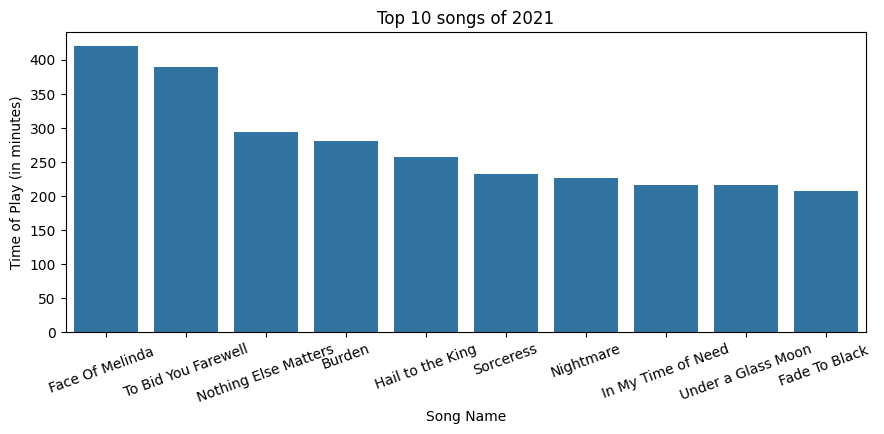

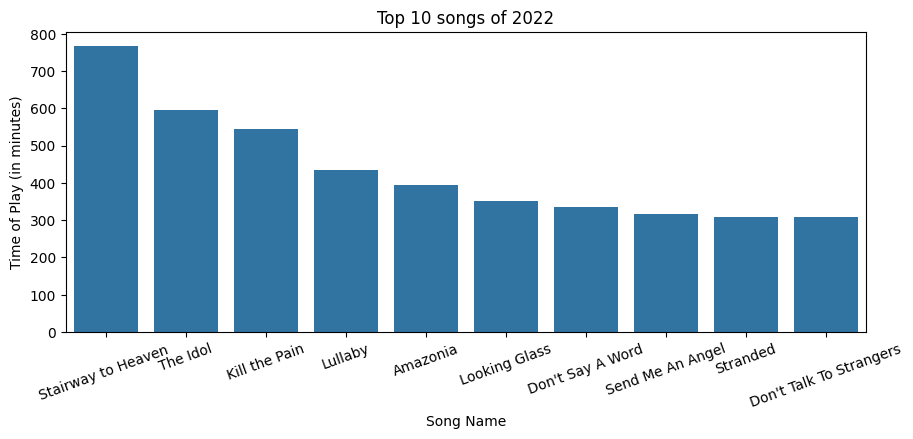

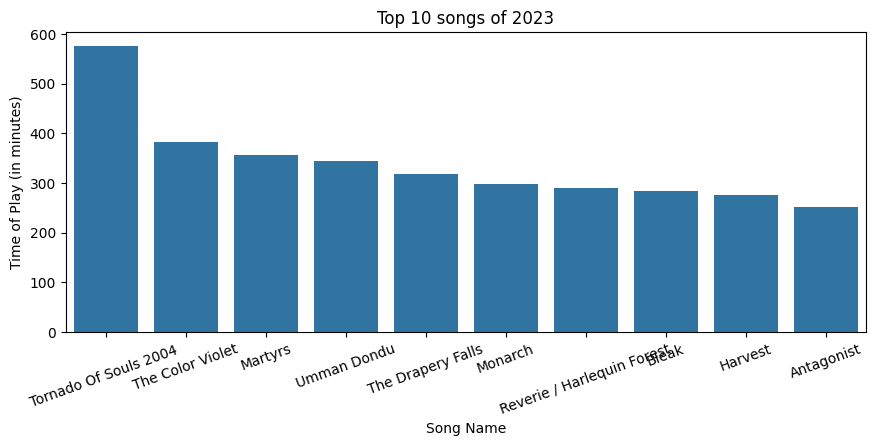

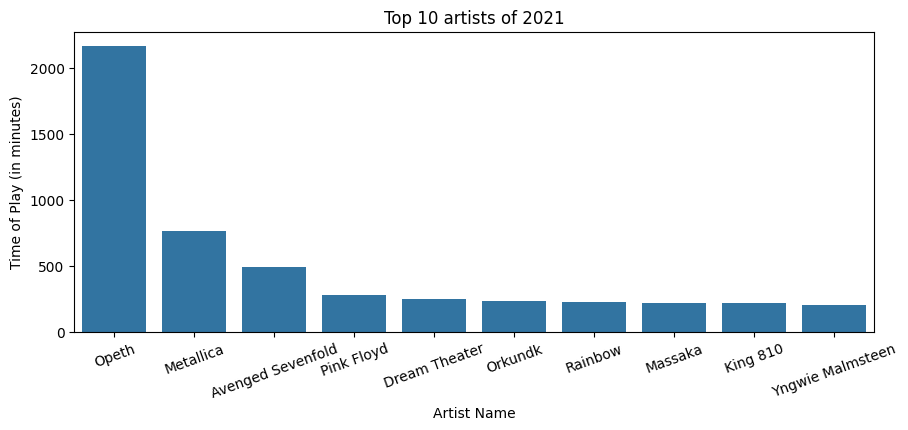

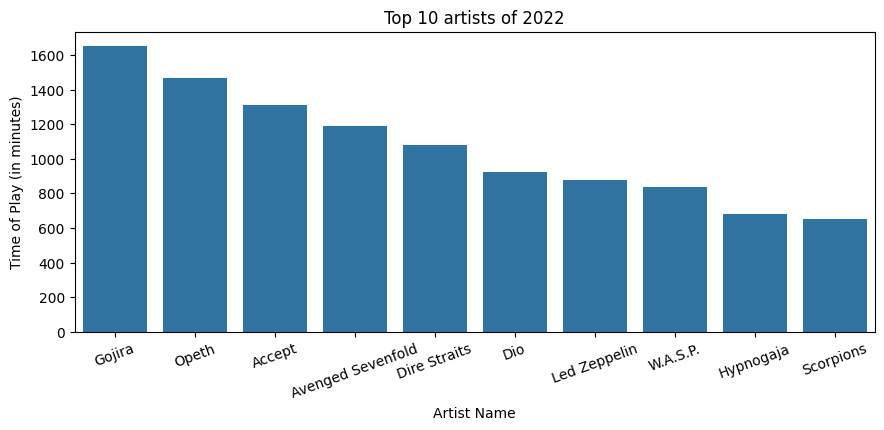

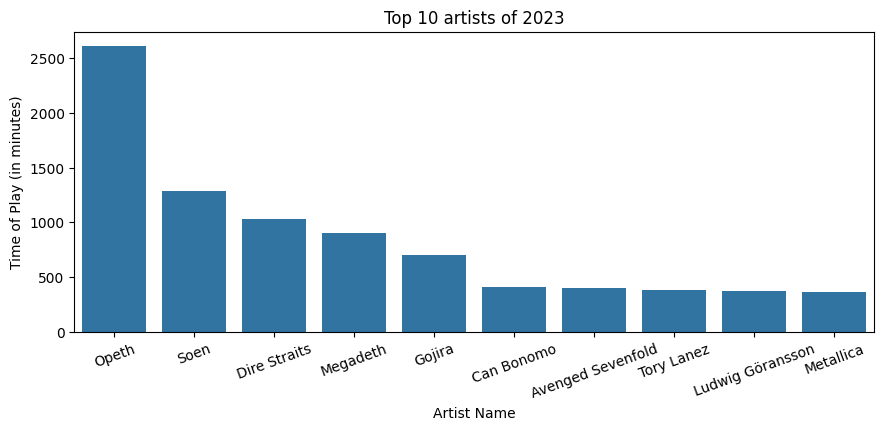

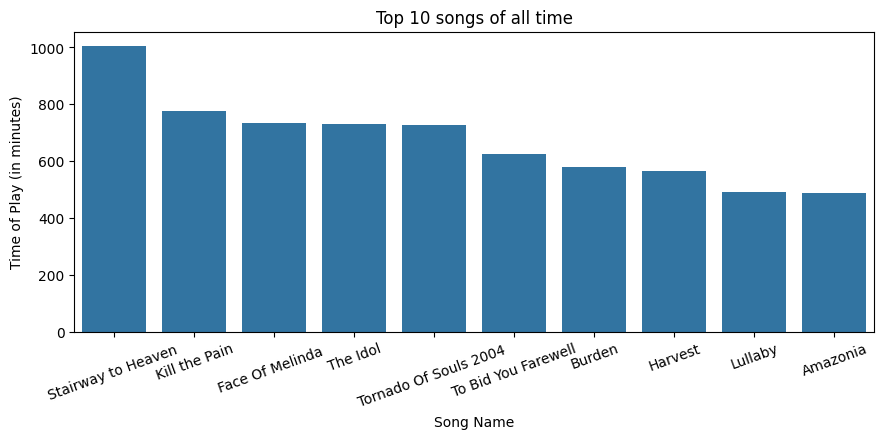

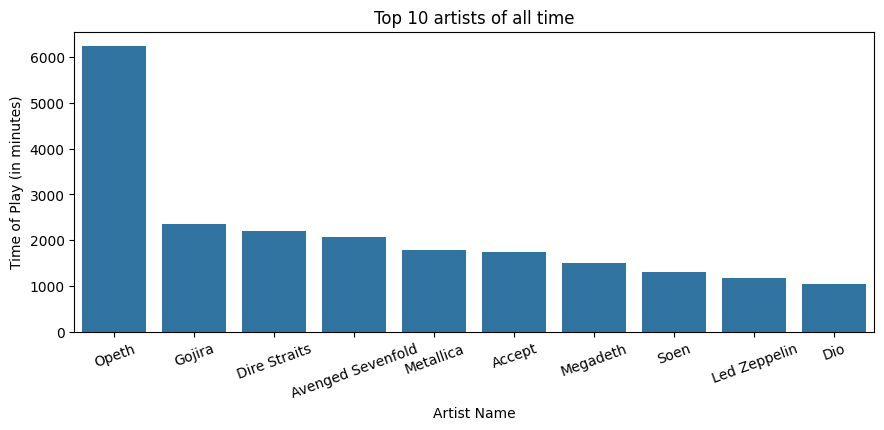

In [68]:


#divide dataframes into years
#2020-2023
merged_df_2021 = merged_df[(merged_df['ts'] >= '2021-01-01') & (merged_df['ts'] <= '2021-12-31, 23:59:59')]
merged_df_2022 = merged_df[(merged_df['ts'] >= '2022-01-01') & (merged_df['ts'] <= '2022-12-31, 23:59:59')]
merged_df_2023 = merged_df[(merged_df['ts'] >= '2023-01-01') & (merged_df['ts'] <= '2023-12-31, 23:59:59')]


#2020-2023, most played songs by play-time in number of minutes
merged_df_2021_dum = (merged_df_2021.groupby(['track_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2021_dum = merged_df_2021_dum/60
merged_df_2022_dum = (merged_df_2022.groupby(['track_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2022_dum = merged_df_2022_dum/60
merged_df_2023_dum = (merged_df_2023.groupby(['track_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2023_dum = merged_df_2023_dum/60



#plot all of them in a bar chart for each year,with seaborn, save them as pngs 
for i in range(2021, 2024):
    df_variable_name = f"merged_df_{i}_dum"  # Adjust based on your actual DataFrame variable names
    current_df = globals()[df_variable_name]  # Access the DataFrame dynamically
    plt.figure(figsize=(10, 5))
    sns.barplot(x=current_df.index, y=current_df.values.flatten())
    plt.title(f'Top 10 songs of {i}')
    plt.xlabel('Song Name')
    plt.ylabel('Time of Play (in minutes)')
    plt.xticks(rotation=20)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)  # Experiment with these values
    plt.savefig(os.path.join('figures',f'top10songs_{i}.png'))
    


#2016-2023 top 10 artists
merged_df_2021_dum = (merged_df_2021.groupby(['artist_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2021_dum = merged_df_2021_dum/60
merged_df_2022_dum = (merged_df_2022.groupby(['artist_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2022_dum = merged_df_2022_dum/60
merged_df_2023_dum = (merged_df_2023.groupby(['artist_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_2023_dum = merged_df_2023_dum/60


#plot all of them in a bar chart for each year, with seaborn, save them as pngs
for i in range(2021, 2024):
    df_variable_name = f"merged_df_{i}_dum"  # Adjust based on your actual DataFrame variable names
    current_df = globals()[df_variable_name]  # Access the DataFrame dynamically
    plt.figure(figsize=(10, 5))
    sns.barplot(x=current_df.index, y=current_df.values.flatten())
    plt.title(f'Top 10 artists of {i}')
    plt.xlabel('Artist Name')
    plt.ylabel('Time of Play (in minutes)')
    plt.xticks(rotation=20)   
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)  # Experiment with these values
    #save to figures folder
    plt.savefig(os.path.join('figures',f'top10artists_{i}.png'))
    

#2020-2023, most played songs by play-time in number of minutes
merged_df_dum = (merged_df.groupby(['track_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_dum = merged_df_dum/60
plt.figure(figsize=(10, 5))
sns.barplot(x=merged_df_dum.index, y=merged_df_dum.values.flatten())
plt.title('Top 10 songs of all time')
plt.xlabel('Song Name')
plt.ylabel('Time of Play (in minutes)')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)  # Experiment with these values
plt.savefig(os.path.join('figures',f'top10songs_alltime.png'))

#2020-2023, most played songs by play-time in number of minutes
merged_df_dum = (merged_df.groupby(['artist_name'])['seconds_played'].sum().sort_values(ascending=False).head(10))
merged_df_dum = merged_df_dum/60
plt.figure(figsize=(10, 5))
sns.barplot(x=merged_df_dum.index, y=merged_df_dum.values.flatten())
plt.title('Top 10 artists of all time')
plt.xlabel('Artist Name')
plt.ylabel('Time of Play (in minutes)')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)  # Experiment with these values
plt.savefig(os.path.join('figures',f'top10artists_alltime.png'))





track_name  minutes_played  danceability  \
0                         Stairway to Heaven      1005.028167        0.5620   
1                               Kill the Pain      778.177833        0.0724   
2                           Face Of Melinda        732.661000        0.6950   
3                                    The Idol      729.322667        0.6720   
4                      Tornado Of Souls 2004       726.301667        0.6950   
...                                       ...             ...           ...   
3608                                 Unspoken        0.000000        0.4640   
3609                                 Upgraded        0.000000        0.2560   
3610                          Gunslinger Live        0.000000        0.1190   
3611  Guns Blazing feat. Dr. Dre & Sly Pyper         0.000000        0.5400   
3612                                 The Kill        0.000000        0.2350   

      energy  key  loudness  mode  speechiness  acousticness  \
0     0.6800    8    -7.582     1       0.3460      0.186000   
1     0.0206    7   -36.143     0       0.0455      0.985000   
2     0.2940    3   -14.537     0       0.2280      0.645000   
3     0.6100   10    -9.442     0       0.0692      0.119000   
4     0.2940    3   -14.537     0       0.2280      0.645000   
...      ...  ...       ...   ...          ...           ...   
3608  0.6120    9   -12.019     1       0.0591      0.116000   
3609  0.9240    7    -6.685     1       0.1130      0.003690   
3610  0.1250    9   -20.239     1       0.0343      0.557000   
3611  0.5840    7    -9.579     1       0.0254      0.010800   
3612  0.9680    1    -4.758     0       0.0901      0.000224   

      instrumentalness  liveness  valence    tempo  
0              0.00000    0.0586   0.1690  119.918  
1              0.09040    0.0860   0.0313   77.025  
2              0.00204    0.1180   0.3240  156.055  
3              0.00000    0.1490   0.4850  103.069  
4              0.00204    0.1180   0.3240  156.055  
...                ...       ...      ...      ...  
3608           0.00559    0.1710   0.4960   91.499  
3609           0.23400    0.1140   0.2800  113.574  
3610           0.91000    0.1080   0.0512  172.654  
3611           0.00296    0.2530   0.2440  139.261  
3612           0.00000    0.2250   0.2770   87.955  

[3613 rows x 13 columns]

C:\Users\Baran\AppData\Local\Temp\ipykernel_5012\4148967133.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


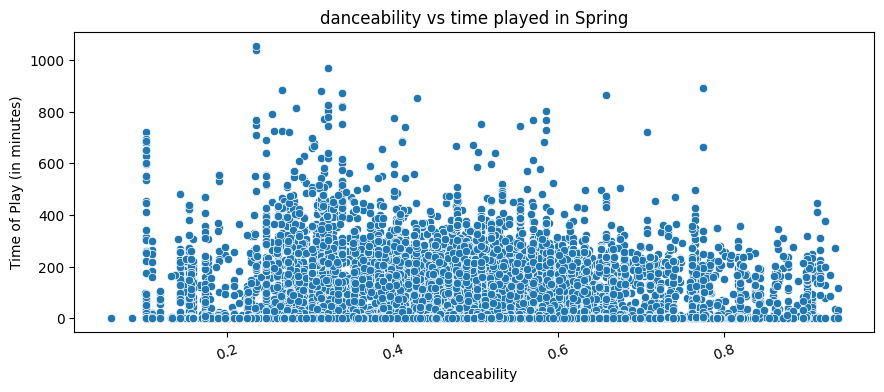

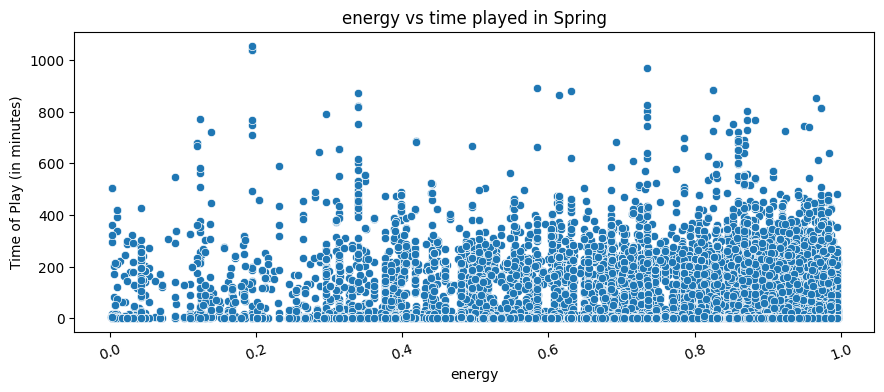

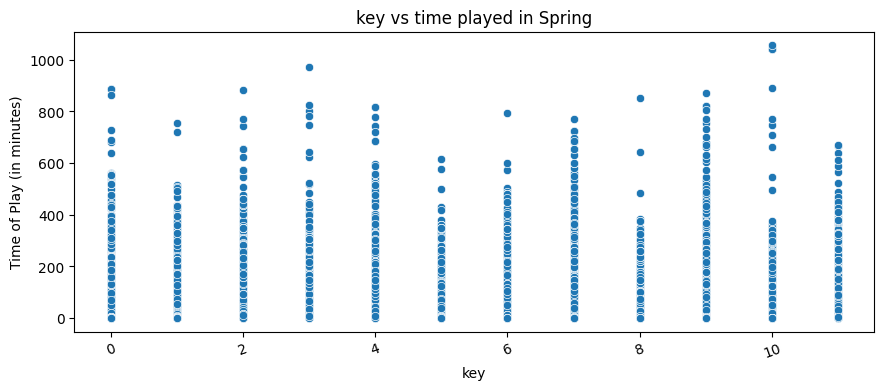

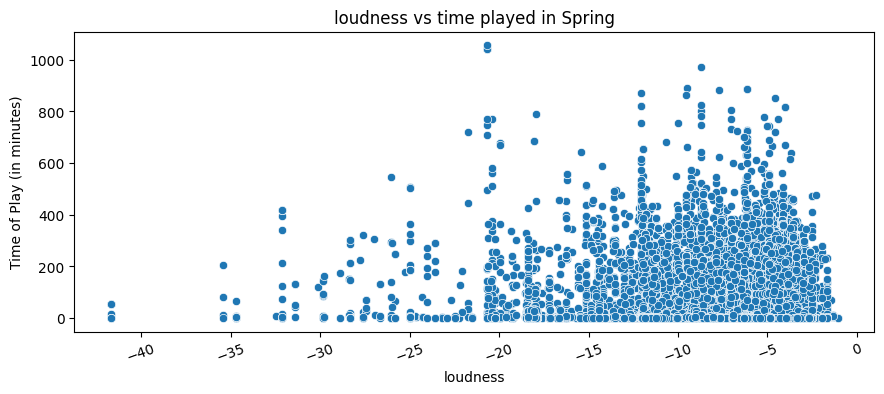

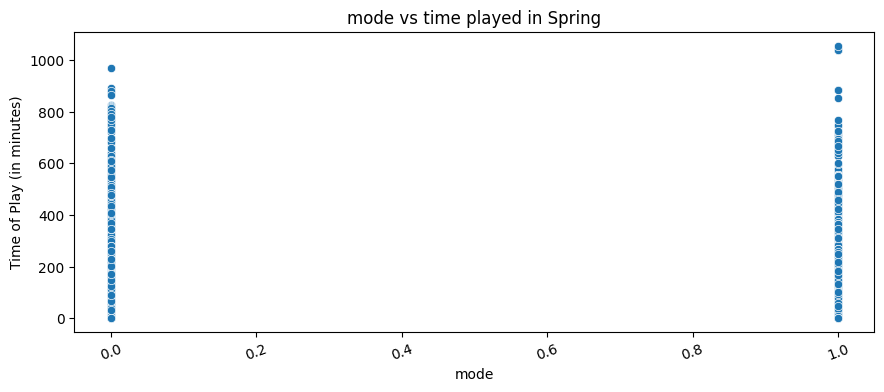

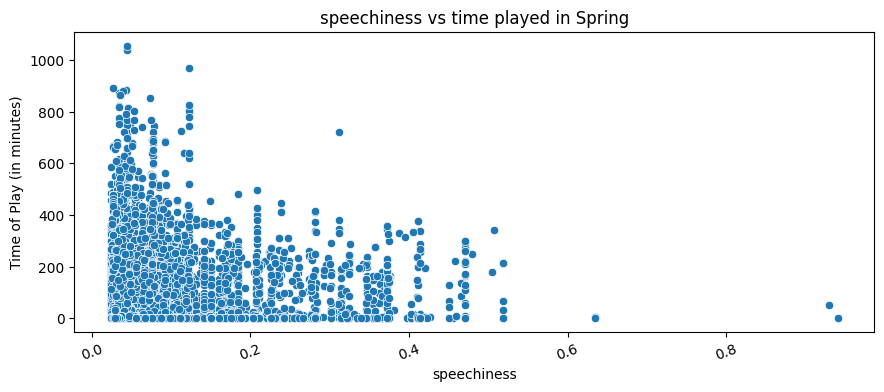

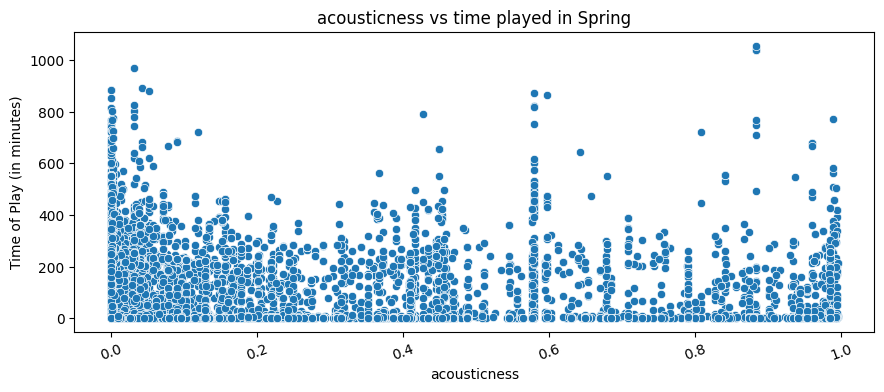

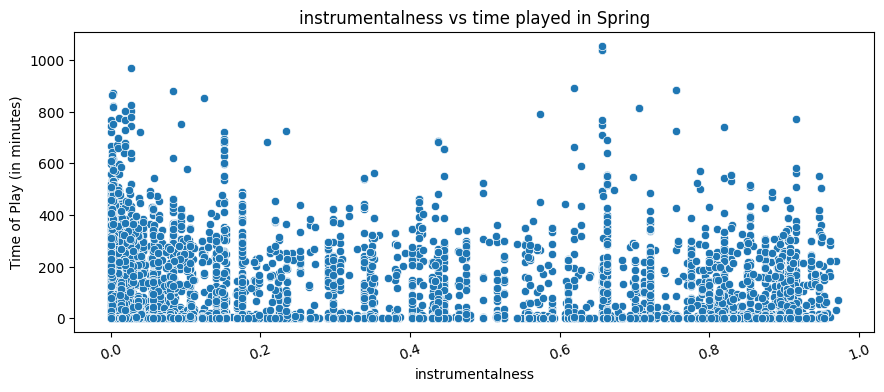

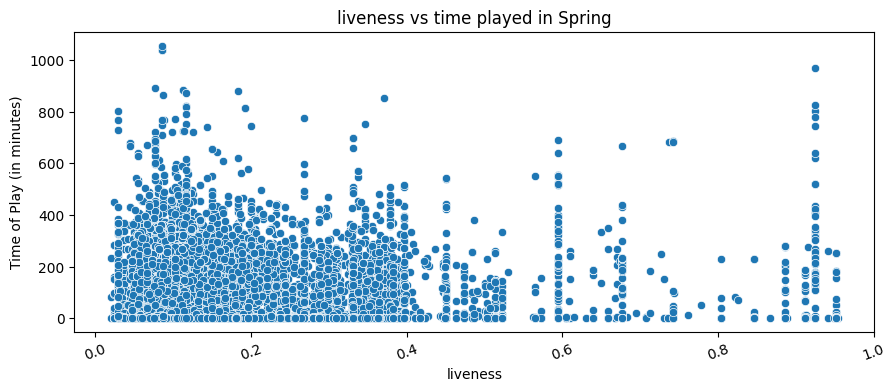

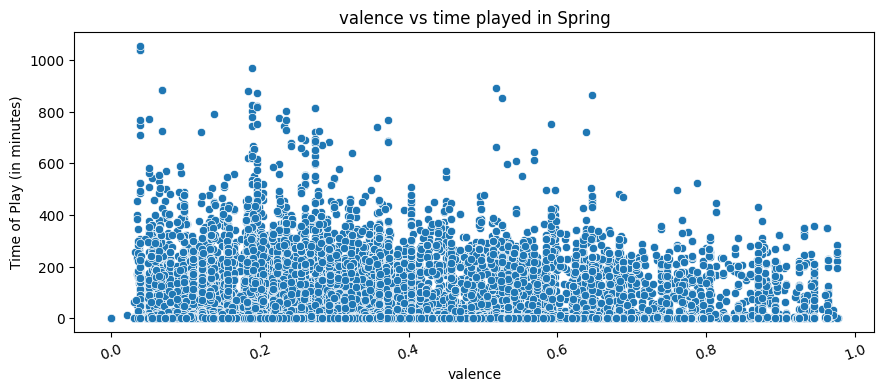

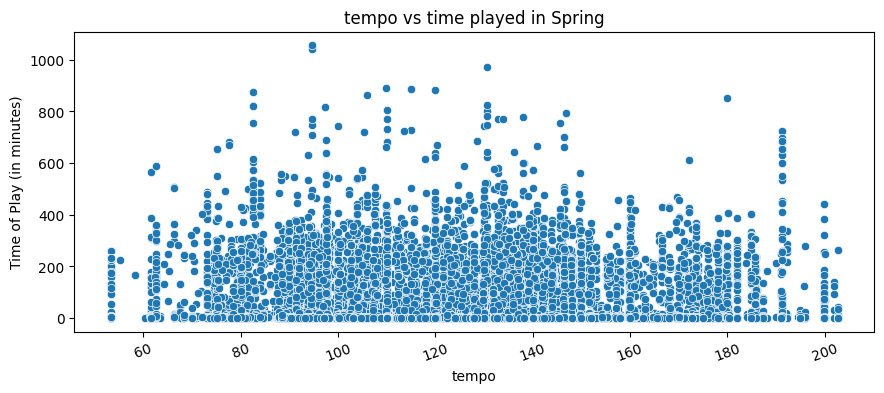

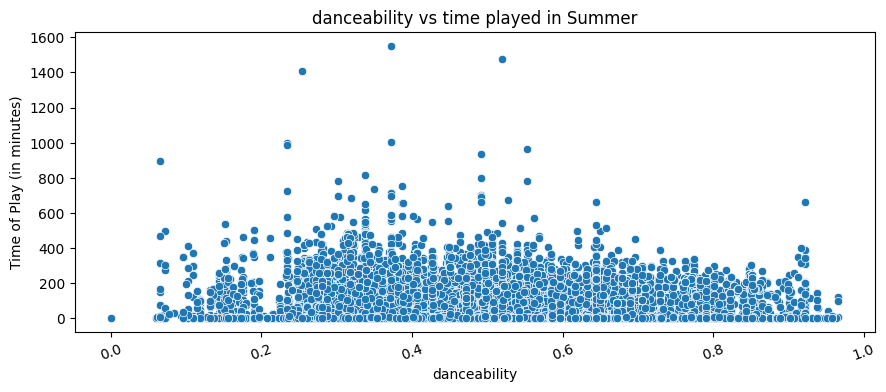

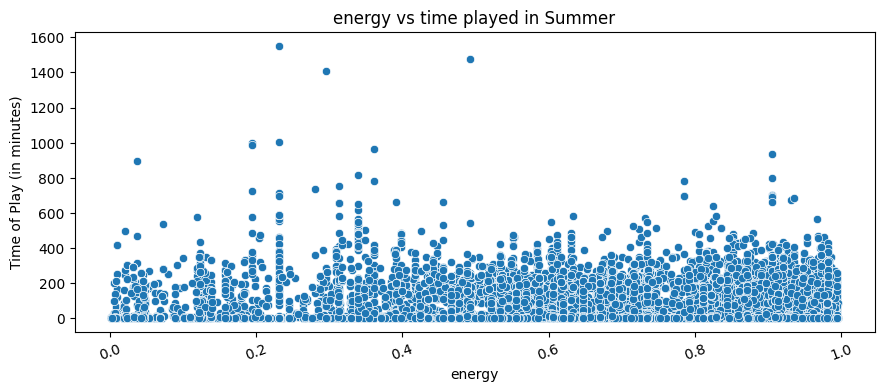

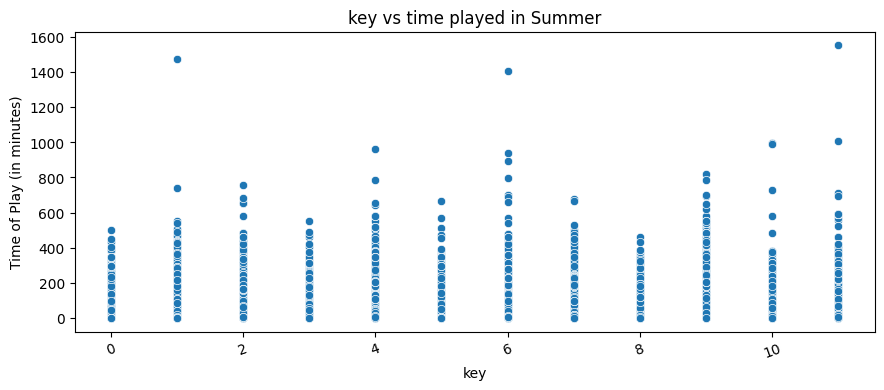

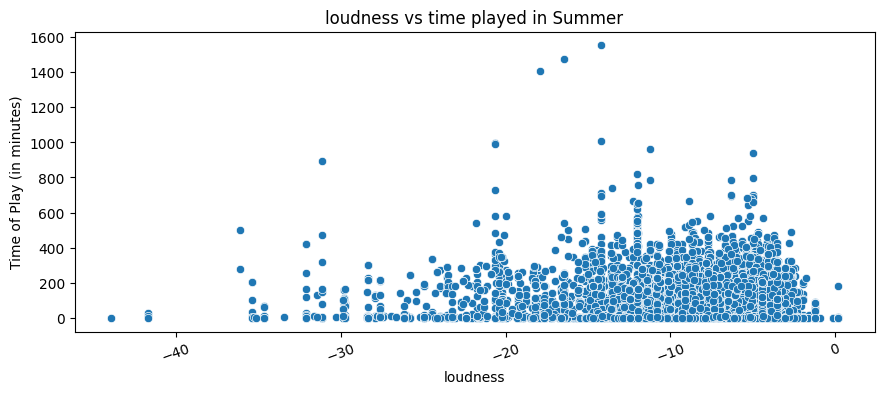

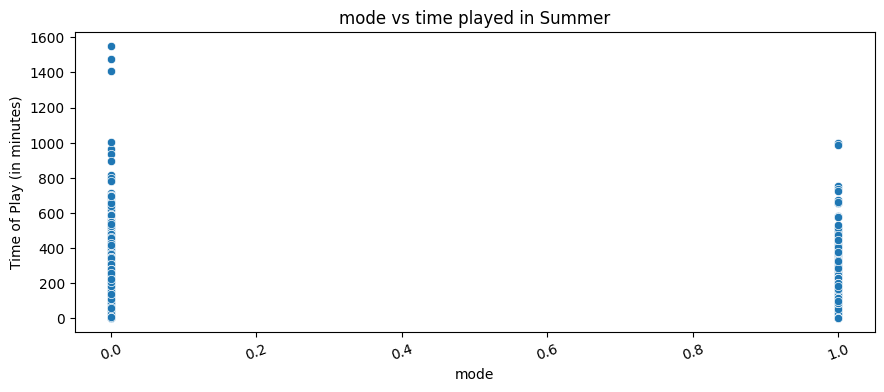

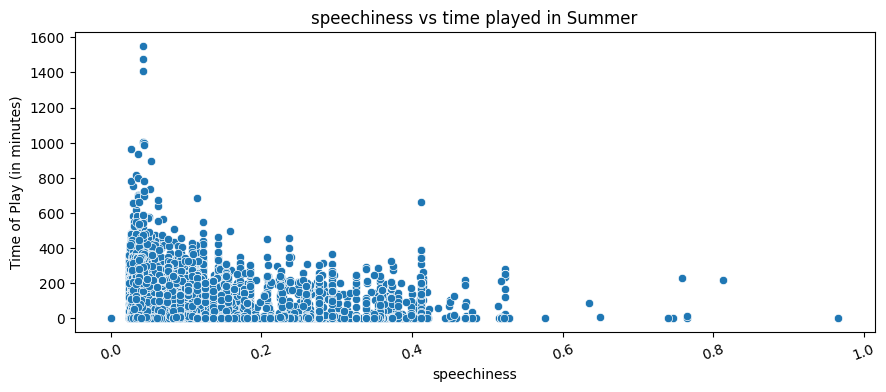

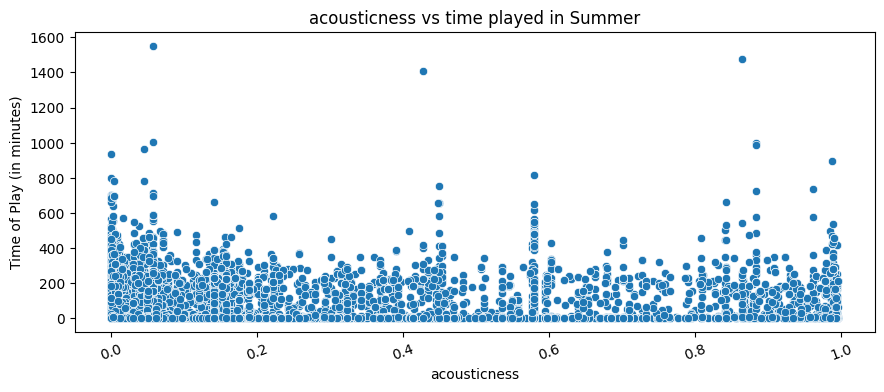

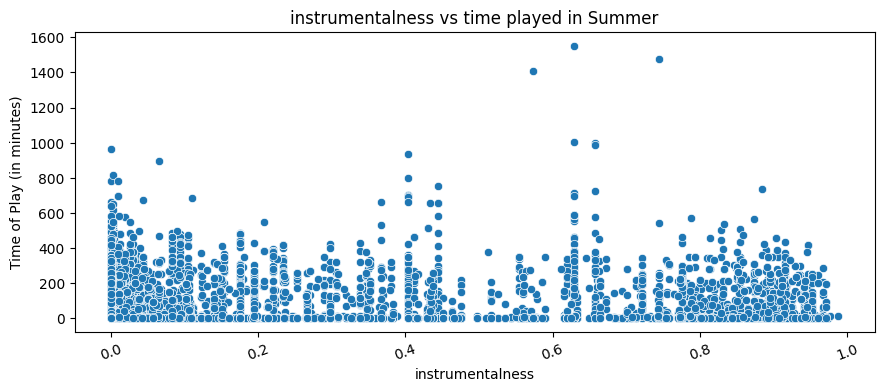

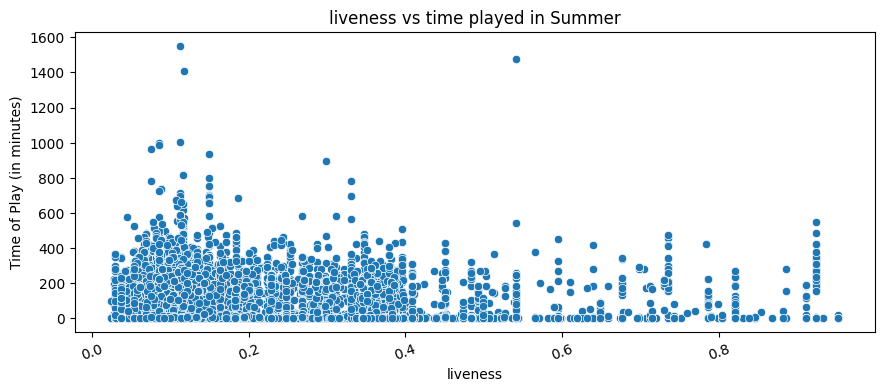

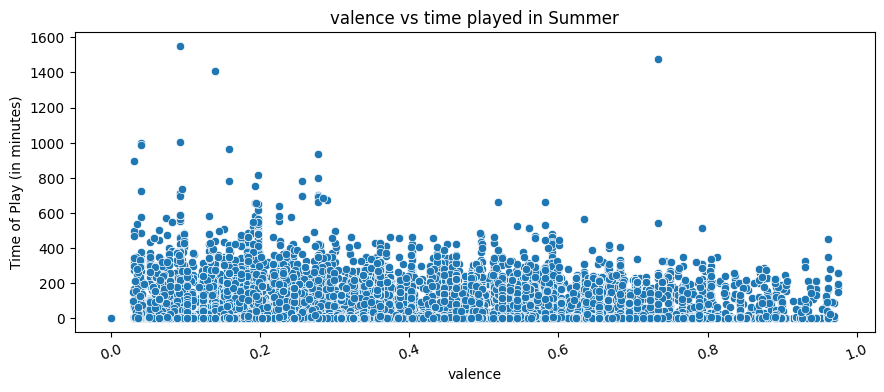

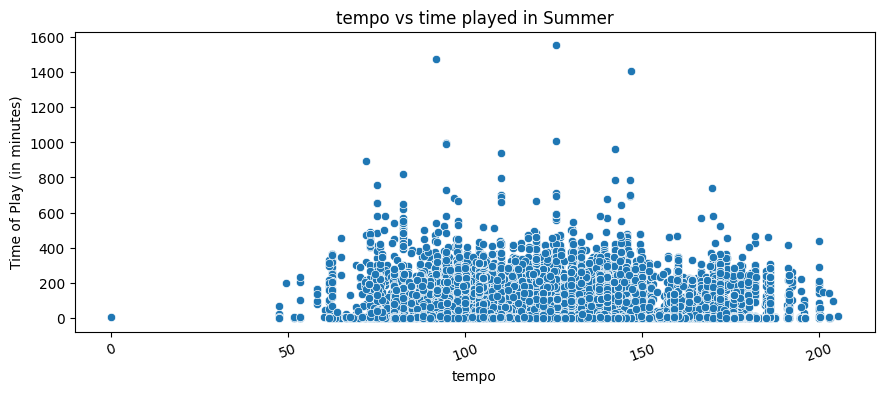

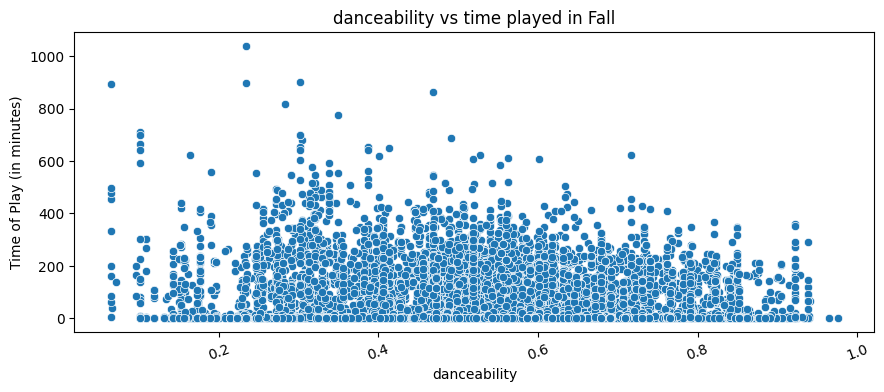

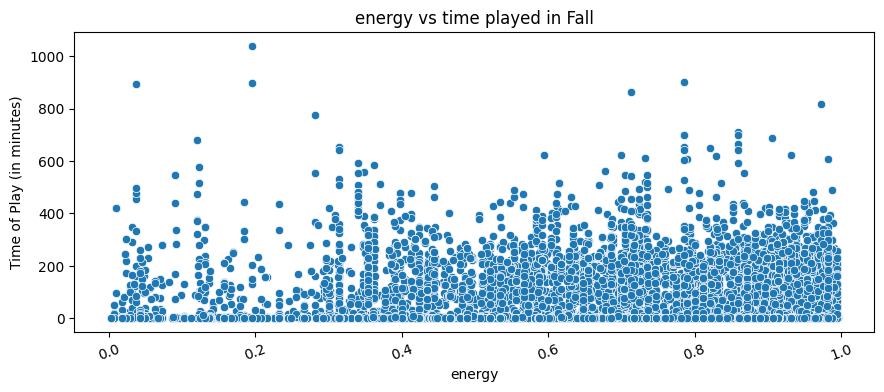

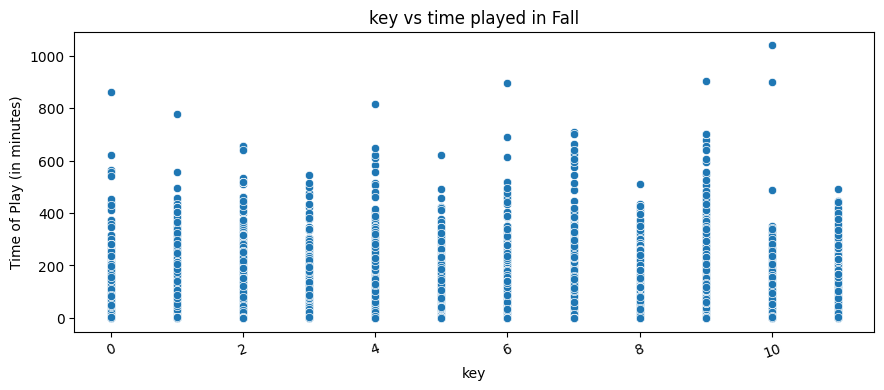

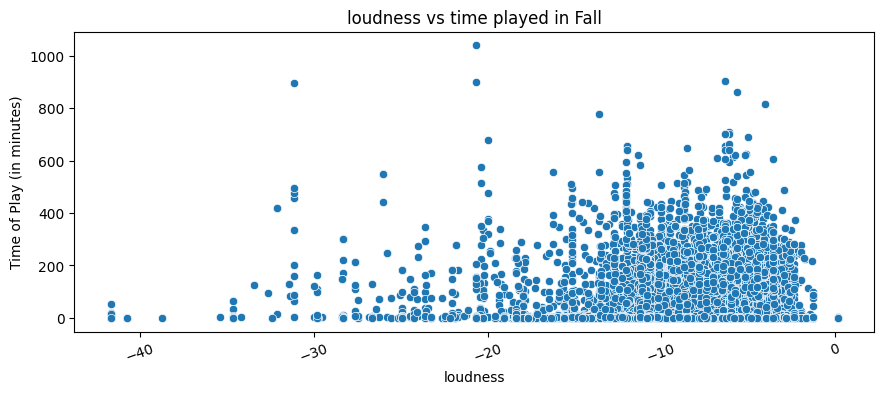

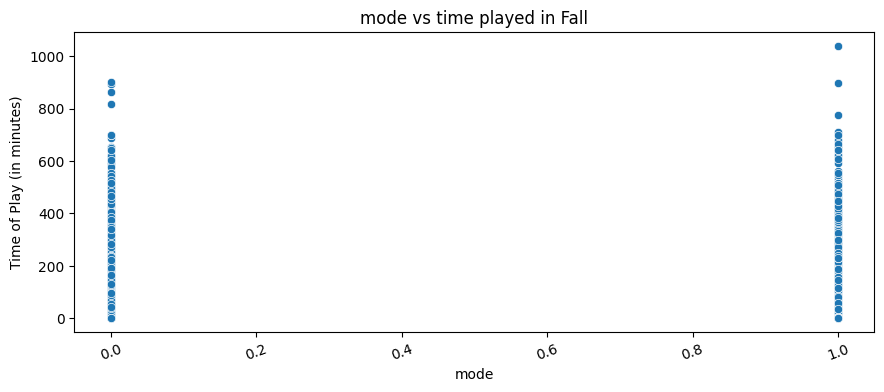

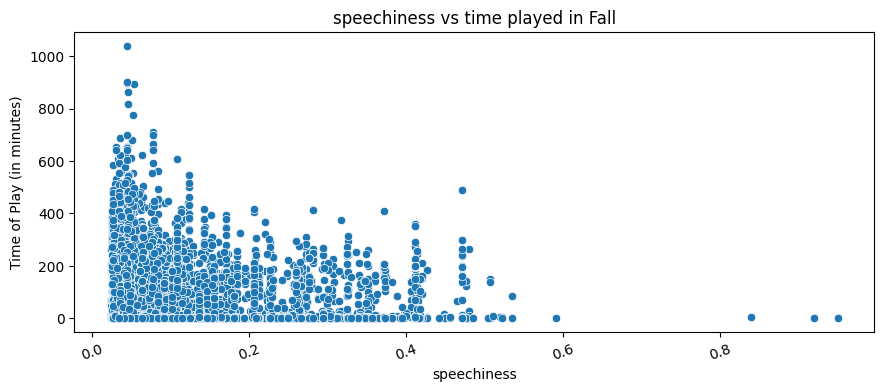

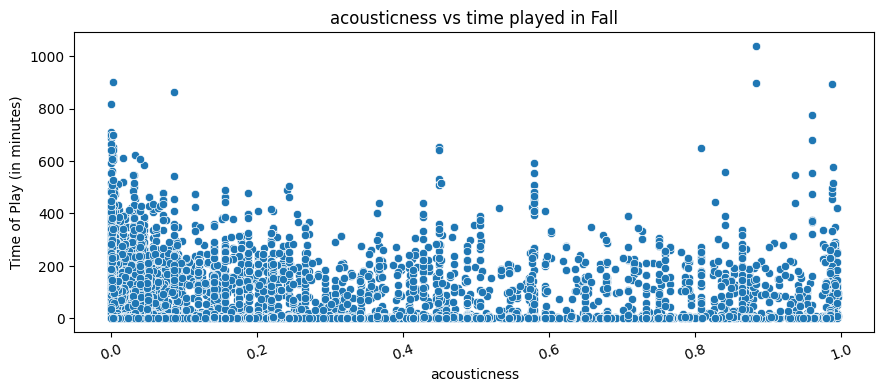

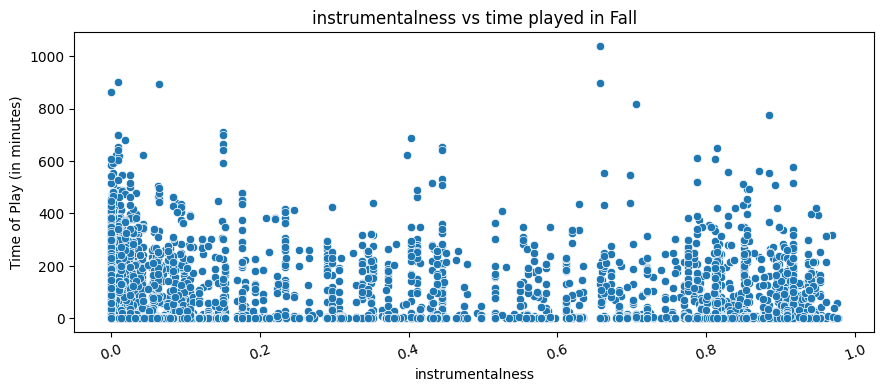

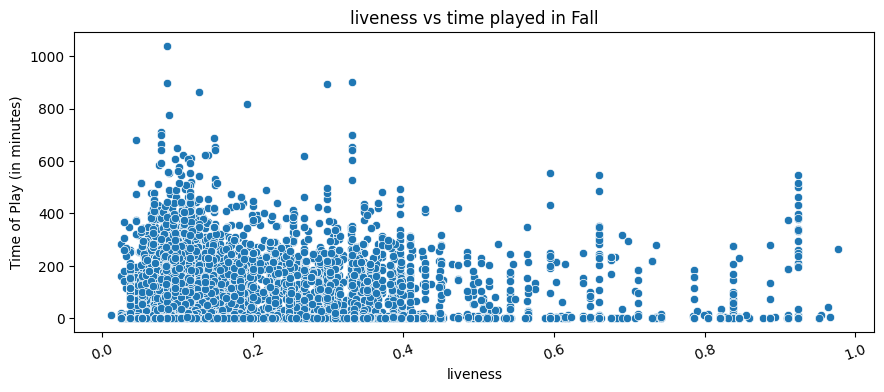

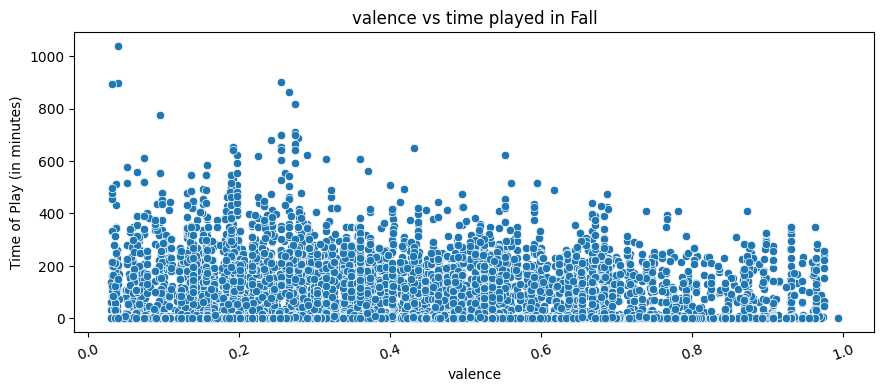

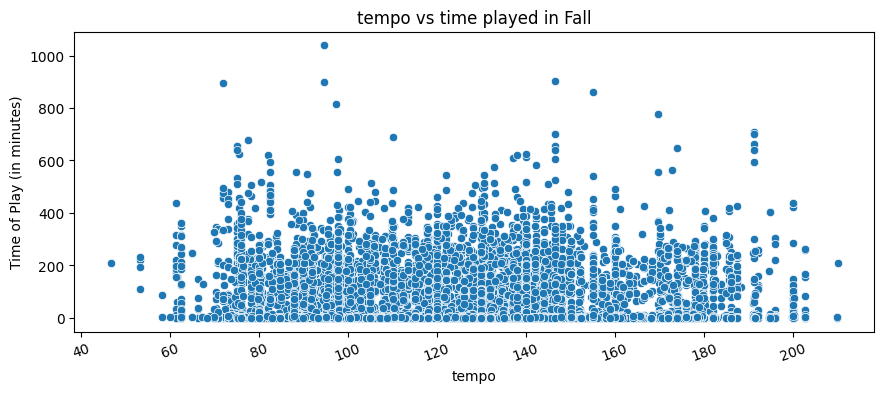

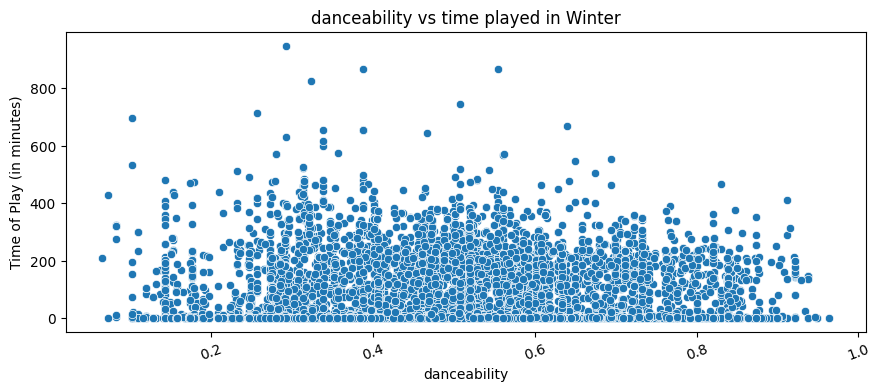

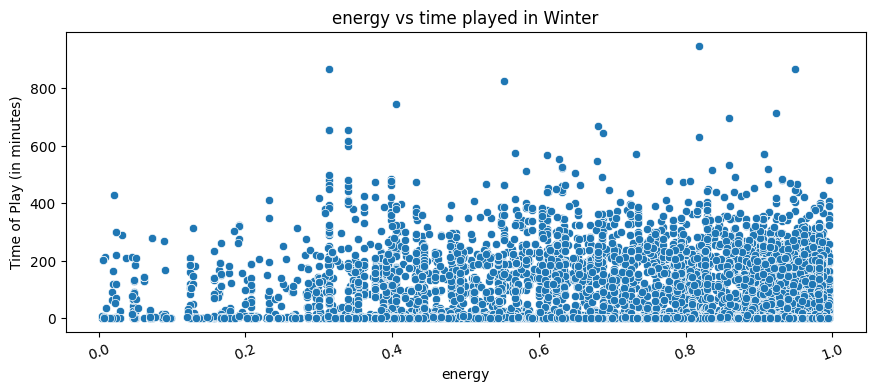

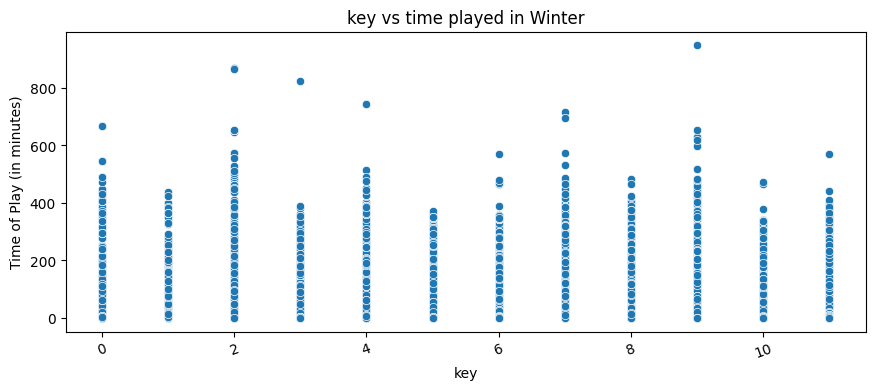

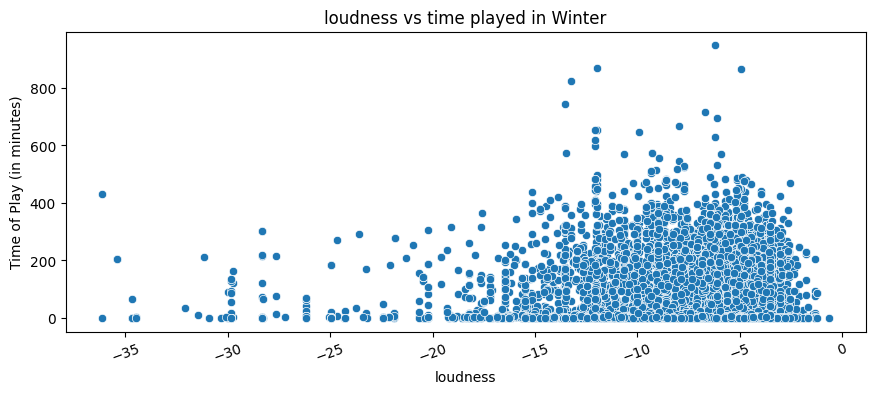

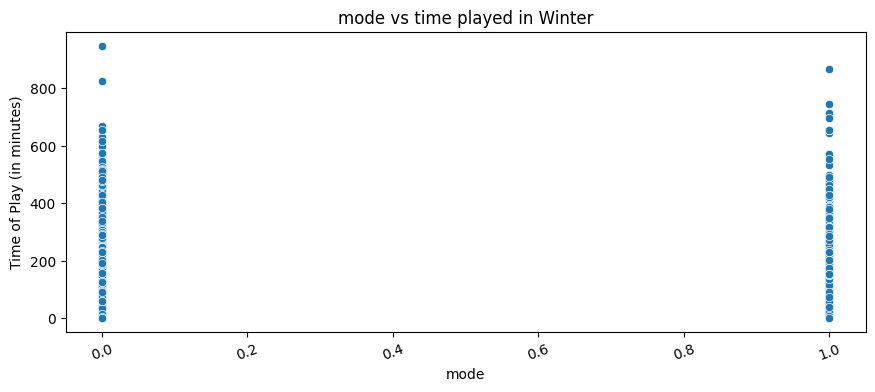

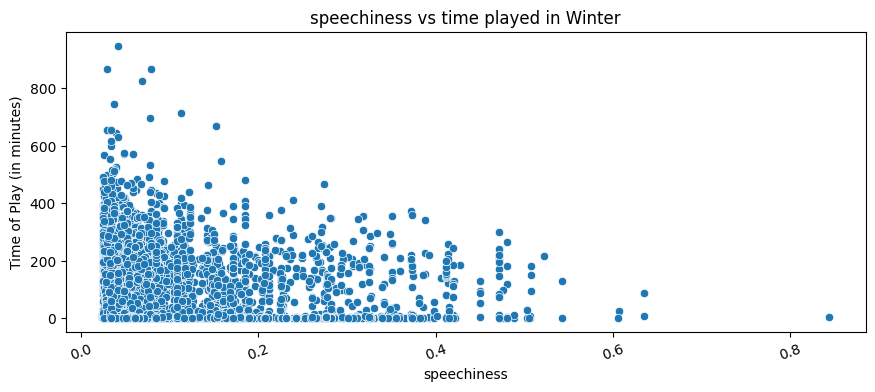

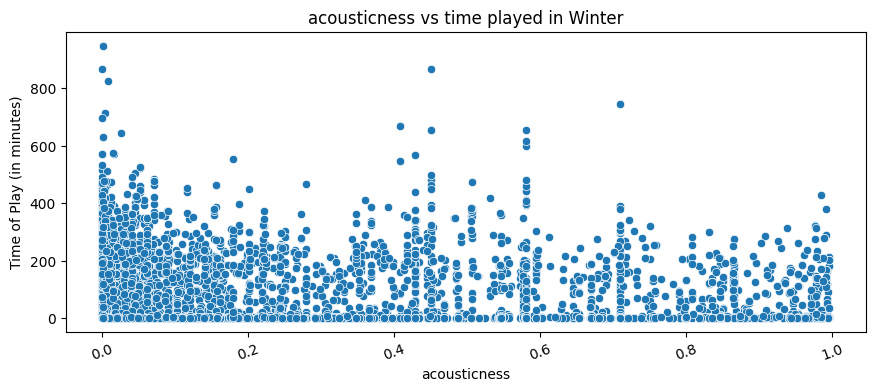

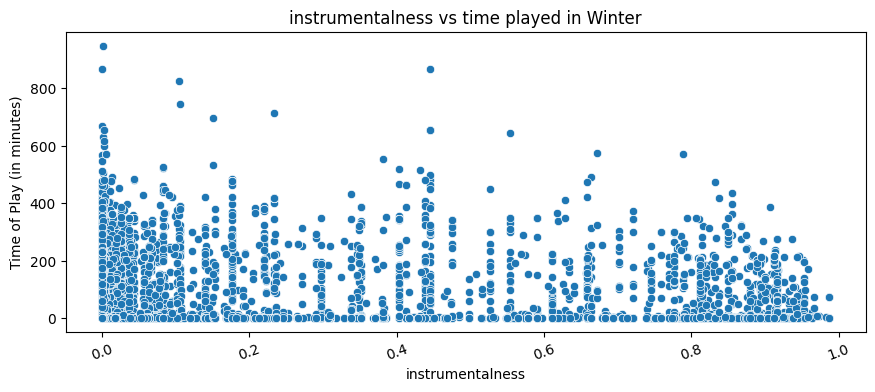

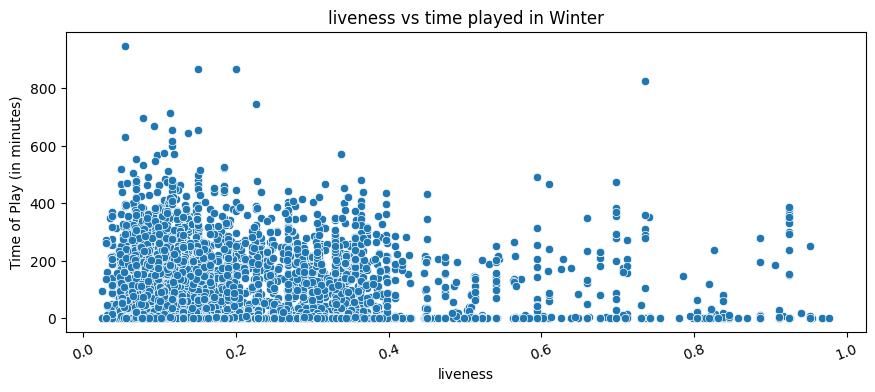

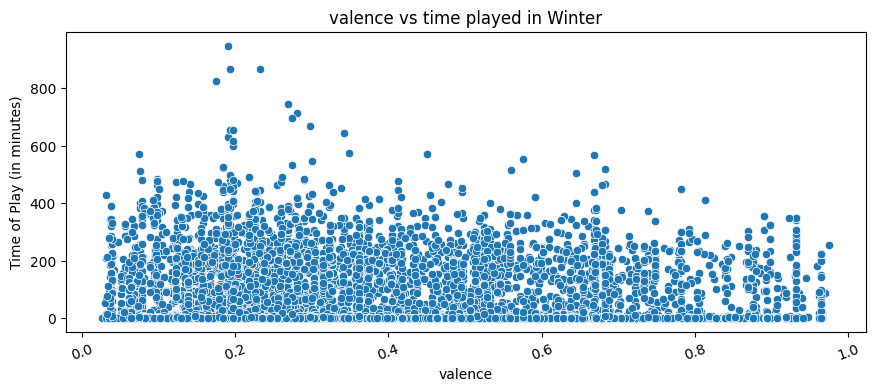

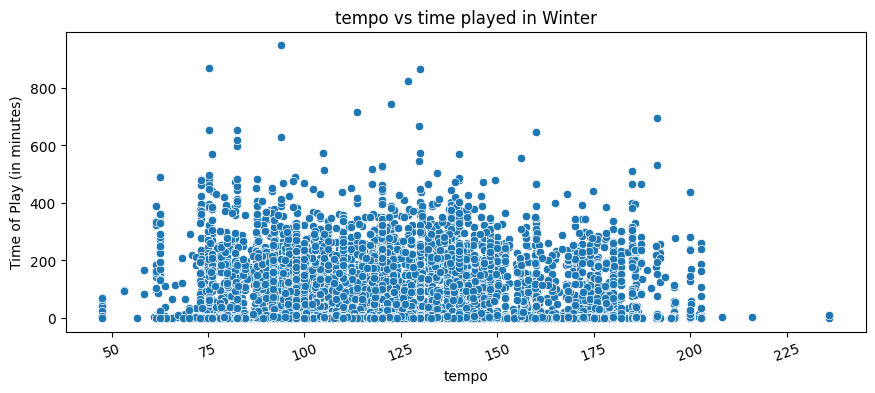

In [69]:
#for each season, plot the scatter plot of the audio features of the songs
# Define the column list
df_audio_features = merged_df.copy()

#scatter plot of audio features for each season
# Define the column list
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

df_audio_features_Track = (df_audio_features.groupby(['track_name'])['seconds_played'].sum().sort_values(ascending=False))
df_audio_features_Track = df_audio_features_Track/60
df_audio_features_Track = df_audio_features_Track.reset_index()
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_audio_features_Track[audio_features] = df_audio_features[audio_features]
df_audio_features_Track.rename(columns={'seconds_played': 'minutes_played'}, inplace=True)
display(df_audio_features_Track)


#iterate through each season
for term in seasons:
    df_audio_features_perSeason = df_audio_features[df_audio_features['season'] == term]
    #scatter plot of time played vs audio features
    for feature in audio_features:
        plt.figure(figsize=(10, 5))
        sns.scatterplot(x=feature, y='seconds_played', data=df_audio_features_perSeason)
        plt.title(f'{feature} vs time played in {term}')
        plt.xlabel(f'{feature}')
        plt.ylabel('Time of Play (in minutes)')
        plt.xticks(rotation=20)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
        plt.savefig(os.path.join('figures',f'{feature}_vs_timeplayed_{term}.png'))
    


In [70]:
#add a new column to the dataframe that has the time period of the day
def get_time_period(hour):
    hour = int(hour)
    if 0 <= hour <= 5:
        return 'Late Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'


# Create a new 'time_period' column based on the 'ts' column
df_audio_features['time_period'] = df_audio_features['ts'].dt.hour.apply(get_time_period)

# Display value counts of the 'time_period' column
display(df_audio_features['time_period'].value_counts())

time_period
Afternoon     17259
Evening       15308
Morning       14314
Late Night     4697
Name: count, dtype: int64

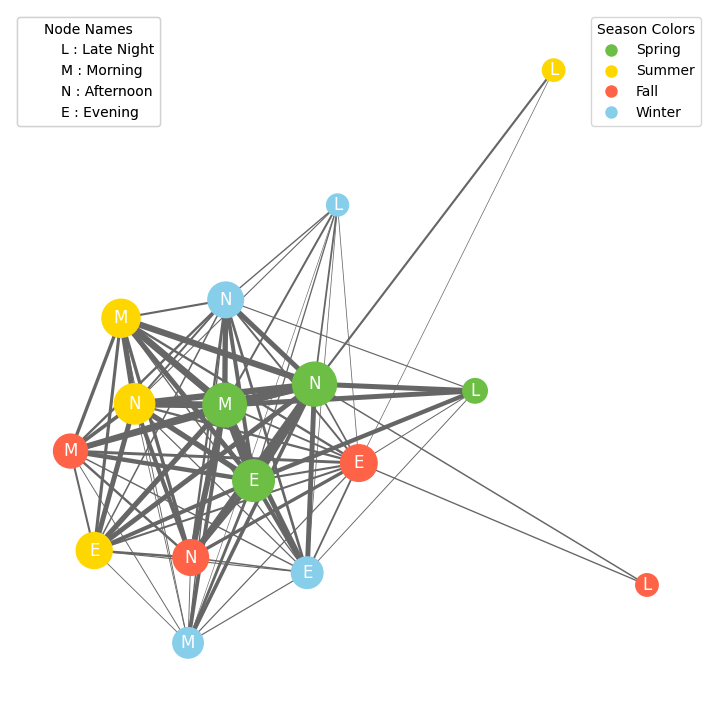

In [71]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named df_audio_features with columns: time_period, season, artist_name, seconds_played
# Filter out songs played for less than 15 seconds
df_for_graph = df_audio_features[df_audio_features['seconds_played'] >= 15].copy()
df_for_graph = df_for_graph.reset_index(drop=True)

# Create a graph
G = nx.Graph()

# Calculate node sizes based on the number of songs played in each time_period/season tuple
node_size = df_for_graph.groupby(['time_period', 'season']).size().to_dict()
# Normalize the node sizes and distribute them within a specified range
min_node_size = 50
max_node_size = 200
node_sizes = [size for size in node_size.values()]
normalized_node_sizes = [min_node_size + (max_node_size - min_node_size) * (size - min(node_sizes)) / (max(node_sizes) - min(node_sizes)) for size in node_sizes]
# Add nodes to the graph with normalized sizes
for (time_period, season), size in zip(node_size.keys(), normalized_node_sizes):
    G.add_node((time_period, season), size=size)

# Add edges based on the same artist with edge weight proportional to the number of occurrences
edge_weight = df_for_graph.groupby(['time_period', 'season', 'track_name']).size().to_dict()
for edge in nx.non_edges(G):
    (time_period1, season1), (time_period2, season2) = edge
    singers1 = set(df_for_graph[(df_for_graph['time_period'] == time_period1) & (df_for_graph['season'] == season1)]['track_name'].unique())
    singers2 = set(df_for_graph[(df_for_graph['time_period'] == time_period2) & (df_for_graph['season'] == season2)]['track_name'].unique())
    
    shared_singers = singers1.intersection(singers2)
    if shared_singers:
        weight = sum(edge_weight.get((time_period1, season1, singer), 0) for singer in shared_singers)
        min_thickness = 1
        max_thickness = 8
        weight = min_thickness + (max_thickness - min_thickness) * (weight - min(edge_weight.values())) / (max(edge_weight.values()) - min(edge_weight.values()))
        if weight > 85:
            G.add_edge((time_period1, season1), (time_period2, season2), weight=weight, thickness=weight**2/19000)

# Choose a layout for better visualization with edge weights as distance parameter
seed_value = 41  # You can choose any integer value as the seed
pos = nx.spring_layout(G, weight='weight', seed=seed_value, k=8)

# Draw the graph with normalized node sizes, colors, and shapes
fig, ax = plt.subplots(figsize=(9, 9),facecolor='#F0F0F0')  # Create figure without setting facecolor

season_colors = {
    'Spring': '#6DBE45',  # Lively green
    'Summer': '#FFD700',  # Sunny yellow
    'Fall': '#FF6347',    # Warm orange
    'Winter': '#87CEEB',   # Icy blue
    }
node_colors = [season_colors[season] for time_period, season in G.nodes]

time_period_names = {'Late Night': 'L' , 'Morning': 'M', 'Afternoon': 'N', 'Evening': 'E'}
time_period_names_dum = {'L : Late Night': 'L' , 'M : Morning': 'M', 'N : Afternoon': 'N', 'E : Evening': 'E'}

edge_thickness = [G[u][v]['thickness'] for u, v in G.edges()]


# Draw the nodes
nx.draw(G, pos, with_labels=False, node_size=[size * 5 for size in normalized_node_sizes], node_color=node_colors, width=edge_thickness, edge_color='#666666')

# Draw the node labels with white color
node_labels = {node: time_period_names[node[0]] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='w', font_size=12)


# Add a legend for node labels / Add a  legend for season colors
legend_handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in season_colors.items()]
first_legend = plt.legend(handles=legend_handles1, title='Season Colors', loc='upper right')
plt.gca().add_artist(first_legend)
# Add a legend for node label name meanings
legend_handles2 = [plt.Line2D([0], [0], color='w', markerfacecolor='w', markersize=10, label=meaning) for meaning,short  in time_period_names_dum.items()]
second_legend = plt.legend(handles=legend_handles2, title='Node Names', loc='upper left')
plt.gca().add_artist(second_legend)


ax.set_facecolor('#F0F0F0')
plt.savefig(os.path.join('figures', 'graph.png'), facecolor='#F0F0F0', bbox_inches='tight')
 



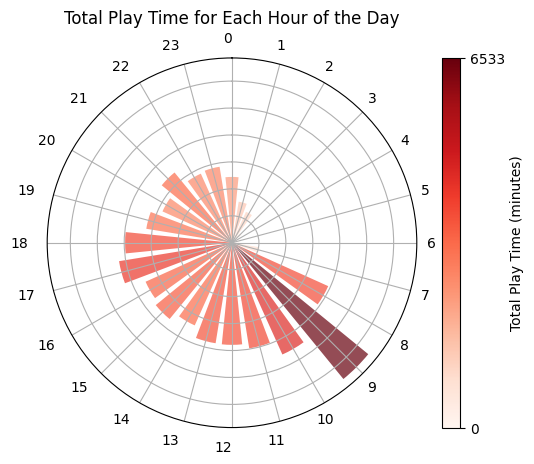

In [80]:
# WE will create a clock graph for each hour of the day

### Inspiration from r-beginners on stackoverflow
##https://stackoverflow.com/questions/72595317/is-it-possible-to-generate-a-clock-chart-using-plotly


# Create a DataFrame for each hour of the day
# We will have 24 rows for each hour and 1 column indicating the total play time of that hour
df_audio_features['hour'] = df_audio_features['ts'].dt.hour
df_hourly = df_audio_features.groupby(['hour'])['seconds_played'].sum().reset_index()

df_hourly = df_hourly.rename(columns={'seconds_played': 'total_seconds_played', 'hour': 'hour_name'})

# Display the resulting DataFrame

# Convert total play time from seconds to minutes
df_hourly['total_minutes_played'] = df_hourly['total_seconds_played'] / 60

# Assuming 'r' is a list of total play time for each hour
r = df_hourly['total_minutes_played'].tolist()

# Convert 'r' to a NumPy array before normalization
r_array = np.array(r)


# Normalize 'r' to be between 0 and 1
normalized_r = np.array(r) / max(r)

# Create an array of angles (theta) for each hour
theta = np.linspace(0, 2*np.pi, len(r), endpoint=False)  # Revert to original starting point

# Plot the polar heatmap
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

from matplotlib.colors import Normalize
# Use bar to create colored bars
bars = ax.bar(theta, r_array, width=0.2, alpha=0.7, color=plt.cm.Reds(Normalize()(r_array)))  # Use Normalize to map values

# Add colorbar with real values
maxImum = max(df_hourly['total_minutes_played'])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds', norm=Normalize(vmin=0, vmax=maxImum)), ax=ax, ticks=np.arange(0, maxImum+ 1, maxImum))
cbar.set_label('Total Play Time (minutes)')

# Customize the appearance of the plot
ax.set_xticks(theta)
ax.set_xticklabels(df_hourly['hour_name'], rotation=45, ha='right')  # Rotate the labels for better visibility
ax.set_yticklabels([])

ax.set_theta_offset(np.pi/2)  # Rotate the plot so that the hour on top is 0
ax.set_theta_direction(-1)  # Make the bars go clockwise

ax.set_title('Total Play Time for Each Hour of the Day')

plt.savefig(os.path.join('figures', 'clock.png'), facecolor='#F0F0F0', bbox_inches='tight')
# Display the plot
plt.show()

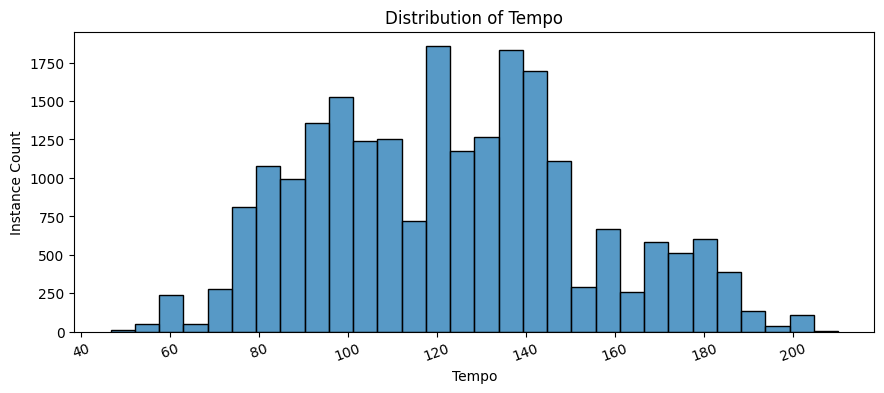

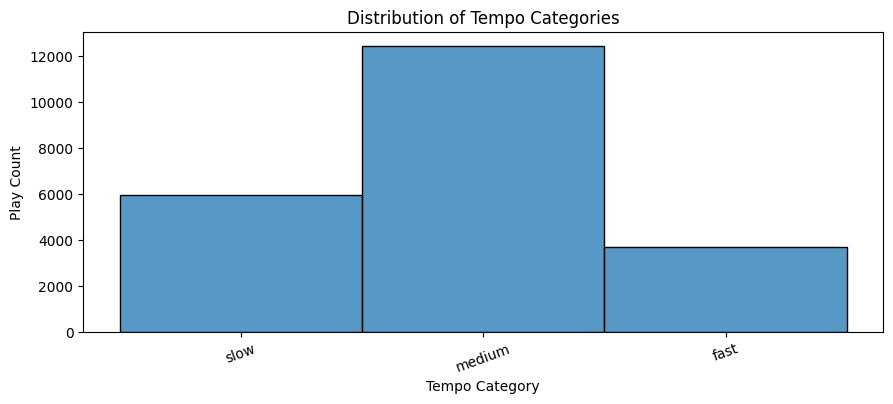

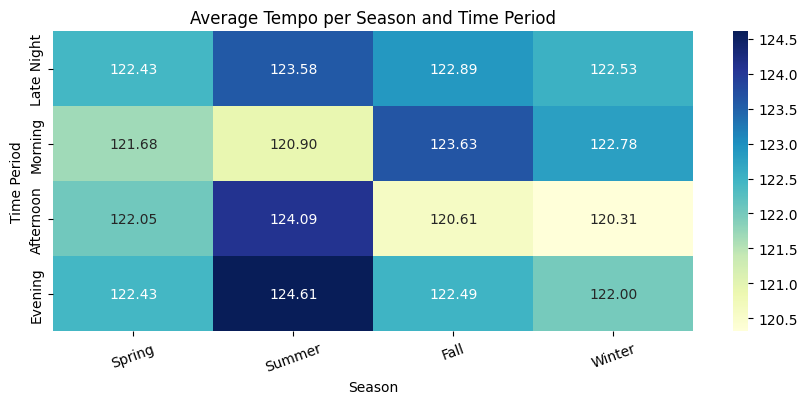

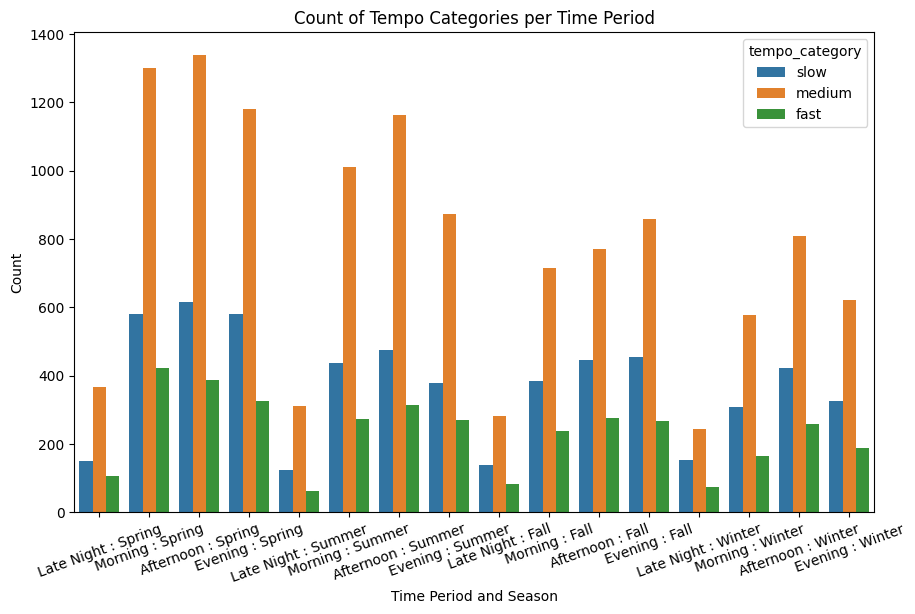

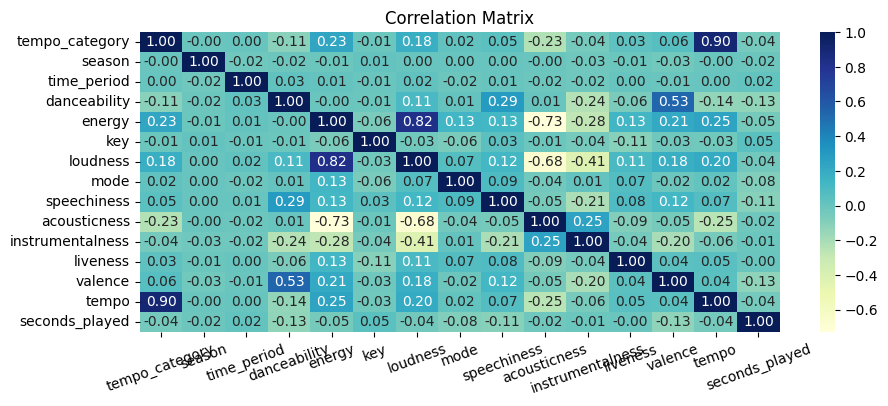

In [73]:
# Given the informatin in the DataFrame df_audio_features, looking at the fatures;
# energy, loudness, valence, tempo
# time_period, season
# Hypothesis: The colder a season is, or the further we are away from 12pm to 17pm, the less tempoed the songs are
# Corolary Hypothesis: The season and the time period of the day are predivtife features for the tempo of a song

# Define the column list of the features we are interested in learning a random forest model
#the target feature tempo is, lets say, divided into categories of slow, medium and fast
# Define the column list
df_audio_features_hypothesis1 = df_audio_features.copy()
#filter out songs that are played for less than 15 seconds


df_audio_features_hypothesis1 = df_audio_features_hypothesis1[df_audio_features_hypothesis1['seconds_played'] >= 15]
df_audio_features_hypothesis1 = df_audio_features_hypothesis1.reset_index(drop=True)
#plot the distribution of the tempo feature as a histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df_audio_features_hypothesis1, x='tempo', bins=30)
plt.title('Distribution of Tempo')
plt.xlabel('Tempo')
plt.ylabel('Instance Count')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures',f'tempo_distribution.png'))

df_audio_features_hypothesis1['tempo_category'] = pd.cut(df_audio_features_hypothesis1['tempo'], bins=[0, 100, 150, 300], labels=['slow', 'medium', 'fast'])
#plot the distribution of the tempo feature as a histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df_audio_features_hypothesis1, x='tempo_category')
plt.title('Distribution of Tempo Categories')
plt.xlabel('Tempo Category')
plt.ylabel('Play Count')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures',f'tempo_category_distribution.png'))


#plot the distribution of the tempo feature corresponding to each season, time period as a heatmap
# Define the column list
# Specify custom order for x and y axis labels
custom_x_order = ['Spring', 'Summer', 'Fall', 'Winter']  # Replace with your actual values
custom_y_order = ['Late Night', 'Morning', 'Afternoon', 'Evening']  # Replace with your actual values

plt.figure(figsize=(10, 5))
sns.heatmap(df_audio_features_hypothesis1.groupby(['time_period', 'season'])['tempo'].mean().unstack(),
            annot=True, cmap='YlGnBu', fmt=".2f",
            xticklabels=custom_x_order,
            yticklabels=custom_y_order
)
plt.title('Average Tempo per Season and Time Period')
plt.xlabel('Season')
plt.ylabel('Time Period')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures',f'tempo_heatmap.png'))


#x axis is the time period,seaon pair, y axis is the tempo category, hue is the count of instances
# Define the column list
# Specify custom order for x and y axis labels
# Specify custom order for x-axis and hue (tempo_category) order
df_audio_features_hypothesis1['time_period_season'] = df_audio_features_hypothesis1['time_period'] + ' : ' + df_audio_features_hypothesis1['season']
custom_x_order = ['Late Night : Spring', 'Morning : Spring', 'Afternoon : Spring', 'Evening : Spring', \
                  'Late Night : Summer', 'Morning : Summer', 'Afternoon : Summer', 'Evening : Summer', \
                    'Late Night : Fall', 'Morning : Fall', 'Afternoon : Fall', 'Evening : Fall', 'Late Night : Winter', \
                        'Morning : Winter', 'Afternoon : Winter', 'Evening : Winter']  # Replace with your actual values
custom_hue_order = ['slow', 'medium', 'fast']  # Replace with your actual values

plt.figure(figsize=(10, 8))
sns.countplot(data=df_audio_features_hypothesis1,
              x='time_period_season',  # Combine 'time_period' and 'season' into a single column
              hue='tempo_category',
              hue_order=custom_hue_order,
              order=custom_x_order)
plt.title('Count of Tempo Categories per Time Period')
plt.xlabel('Time Period and Season')
plt.ylabel('Count')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures', f'tempo_timeperiod_count.png'))
plt.show()

#we need to build a corelation matrix to see which features are correlated with each other
# Define the column list
column_list_corr = ['tempo_category','season','time_period','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','seconds_played']
# Create a new DataFrame with the selected columns
df_audio_features_corr = df_audio_features_hypothesis1[column_list_corr].copy()
# Calculate the correlation matrix
df_audio_features_corr['time_period'] = df_audio_features_corr['time_period'].astype('category').cat.codes
df_audio_features_corr['season'] = df_audio_features_corr['season'].astype('category').cat.codes
df_audio_features_corr['tempo_category'] = df_audio_features_corr['tempo_category'].astype('category').cat.codes

corr_matrix = df_audio_features_corr.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures', f'correlation_matrix.png'))
plt.show()





In [74]:
####COULDNT BEAR TO THROW AYTHING AWAY
#BUT THIS PART OF THE CODE IS NOT USED IN THE PROJECT

#hypothesis 1 and coralerary hypothesis 1 have failed to be proven, lets try to prove hypothesis 2
# Given the informatin in the DataFrame df_audio_features, looking at the fatures; Allbum name, artist name, track name, season, time period;
#we can build a model that gives us a good recomendation of a song to listen to based on the time period and season
#As step 1 we will try to build a ramdom forest model that predicts the action that i am going to take next, based on the features;
#season, time period, current track name,current artist name,current album name, next track name, next artist name, next album name
#if the probility of me passing a song is lowest among all the songs, then the model will recomend me that song
#then we will use a test set to see how well the model performs

#lets see all possible values of the features; reason_start, reason_end
print(df_audio_features['reason_start'].unique())
print(df_audio_features['reason_end'].unique()) 

#lets se the amount of unknownds
print(df_audio_features['reason_start'].value_counts())
print(df_audio_features['reason_end'].value_counts())

#lets replace the values that have unknown values and trackerror values with the value 'unknown'
df_audio_features['reason_start'] = df_audio_features['reason_start'].replace(['unknown','trackerror'],'unknown')
df_audio_features['reason_end'] = df_audio_features['reason_end'].replace(['unknown','trackerror','unexpected-exit'],'unknown')

#lets make the unknown values mod values ot the reason start and reason end columns
##FILL HERE
df_audio_features = df_audio_features[df_audio_features['reason_start'] != 'unknown']
df_audio_features = df_audio_features[df_audio_features['reason_end'] != 'unknown']
df_audio_features = df_audio_features[df_audio_features['reason_start'] != 'unexpected-exit-while-paused']
df_audio_features = df_audio_features[df_audio_features['reason_end'] != 'unexpected-exit-while-paused']
display(df_audio_features['reason_start'].value_counts())
display(df_audio_features['reason_end'].value_counts())


#lets reset the index of the dataframe
df_audio_features = df_audio_features.reset_index(drop=True)
#form now on the data song that is come befor is i-1 and the song that is come after is i+1
#lets create a new column that has the next track name and next artist name 
df_audio_features['next_track_name'] = df_audio_features['track_name'].shift(-1)
df_audio_features['next_artist_name'] = df_audio_features['artist_name'].shift(-1)
 
#can we see a corelation between the season, time period and the reason start and reason end.
# Define a new column; complete action:
df_audio_features['complete_action'] = df_audio_features['reason_start'] + ' -> ' + df_audio_features['reason_end']


'''
#define a new map; UserResponse 
user_response = {'unknown -> fwdbtn' : -3, 'unknown -> endplay' : -1, 
                'unknown -> trackdone' : +5, 'unknown -> backbtn' : 0, 
                'unknown -> logout' : 0, 'unknown -> unexpected-exit-while-paused' : -1, 
                'unknown -> remote' : 0, 'unknown -> unknown' : 0,  
                'fwdbtn -> fwdbtn' : -7, 'fwdbtn -> endplay' : -3, 
                'fwdbtn -> trackdone' : +5, 'fwdbtn -> backbtn' : 0, 
                'fwdbtn -> logout' : 0, 'fwdbtn -> unexpected-exit-while-paused' : -1, 
                'fwdbtn -> remote' : 0, 'fwdbtn -> unknown' :0,
                'clickrow -> fwdbtn' : -3, 'clickrow -> endplay' : -1,
                'clickrow -> trackdone' : +5, 'clickrow -> backbtn' : 0,
                'clickrow -> logout' : 0, 'clickrow -> unexpected-exit-while-paused' : -1,
                'clickrow -> remote' : 0, 'clickrow -> unknown' : 0,
                'trackdone -> fwdbtn' : -7, 'trackdone -> endplay' : -3, 
                'trackdone -> trackdone' : +5, 'trackdone -> backbtn' : 0,
                'trackdone -> logout' : 0, 'trackdone -> unexpected-exit-while-paused' : -1,
                'trackdone -> remote' : 0, 'trackdone -> unknown' : 0,
                'backbtn -> fwdbtn' : 0, 'backbtn -> endplay' : 0,
                'backbtn -> trackdone' : +5, 'backbtn -> backbtn' : 0,
                'backbtn -> logout' : 0, 'backbtn -> unexpected-exit-while-paused' : 0,
                'backbtn -> remote' : 0, 'backbtn -> unknown' : 0,
                'playbtn -> fwdbtn' : -3, 'playbtn -> endplay' : -1,
                'playbtn -> trackdone' : +5, 'playbtn -> backbtn' : 0,
                'playbtn -> logout' : 0, 'playbtn -> unexpected-exit-while-paused' : -1,
                'playbtn -> remote' : 0, 'playbtn -> unknown' : 0,
                'appload -> fwdbtn' : -3, 'appload -> endplay' : -1,
                'appload -> trackdone' : +5, 'appload -> backbtn' : 0,
                'appload -> logout' : 0, 'appload -> unexpected-exit-while-paused' : -1,
                'appload -> remote' : 0, 'appload -> unknown' : 0,
                'remote -> fwdbtn' : -1, 'remote -> endplay' : -1,
                'remote -> trackdone' : +3, 'remote -> backbtn' : 0,
                'remote -> logout' : 0, 'remote -> unexpected-exit-while-paused' : -1,
                'remote -> remote' : 0, 'remote -> unknown' : 0}

#map the user response to the complete action column
df_audio_features['complete_action'] = df_audio_features['complete_action'].map(user_response)


#but if the back button is the reason to start the song and the next song is the same as the current song
#complete action should be 5
df_audio_features.loc[(df_audio_features['reason_start'] == 'backbtn') & (df_audio_features['next_track_name'] == df_audio_features['track_name']), 'complete_action'] = 5  

'''


#we will have 3 sets of data, train, validation and test
shuffle_df = df_audio_features.sample(frac=1,random_state=4).reset_index(drop=True)


sentiment_start_map= {'fwdbtn' : 3, 'clickrow' : 10, 'trackdone' : 0, 'backbtn' : 14, 'playbtn' : 6, 'appload' : 3, 'remote' : 5}
#map it to reason start
shuffle_df['reason_start'] = shuffle_df['reason_start'].map(sentiment_start_map)

display(shuffle_df['reason_start'].value_counts())
display(shuffle_df['reason_end'].value_counts())

# Define the column list
column_list_label = ['season', 'time_period', 'reason_end']
#encode the categorical features with one hot encoding
# Create a LabelEncoder object for each categorical column
label_encoders = {}
for column in column_list_label:
    le = LabelEncoder()
    shuffle_df[column] = le.fit_transform(shuffle_df[column])
    label_encoders[column] = le

train_set = shuffle_df.iloc[:int(0.7*len(shuffle_df))]
val_set = shuffle_df.iloc[int(0.7*len(shuffle_df)):int(0.85*len(shuffle_df))]
test_set = shuffle_df.iloc[int(0.85*len(shuffle_df)):]

display(len(train_set))
display(len(val_set))
display(len(test_set))


['trackdone' 'playbtn' 'clickrow' 'fwdbtn' 'backbtn' 'appload'
 'trackerror' 'unknown' 'remote']
['logout' 'endplay' 'fwdbtn' 'backbtn' 'trackdone'
 'unexpected-exit-while-paused' 'unexpected-exit' 'remote' 'trackerror'
 'unknown']
reason_start
fwdbtn        27847
clickrow      10345
trackdone      8083
backbtn        3373
playbtn        1368
appload         289
remote          252
trackerror       18
unknown           3
Name: count, dtype: int64
reason_end
fwdbtn                          27767
endplay                         10632
trackdone                        8184
backbtn                          3330
logout                            696
unexpected-exit-while-paused      486
remote                            270
unknown                           132
unexpected-exit                    42
trackerror                         39
Name: count, dtype: int64


reason_start
fwdbtn       27677
clickrow     10164
trackdone     7923
backbtn       3328
playbtn       1343
appload        273
remote         154
Name: count, dtype: int64

reason_end
fwdbtn       27761
endplay      10624
trackdone     8183
backbtn       3328
logout         696
remote         270
Name: count, dtype: int64

reason_start
3     27950
10    10164
0      7923
14     3328
6      1343
5       154
Name: count, dtype: int64

reason_end
fwdbtn       27761
endplay      10624
trackdone     8183
backbtn       3328
logout         696
remote         270
Name: count, dtype: int64

35603

7629

7630

Index(['track_name', 'artist_name', 'album_name', 'reason_start', 'reason_end',
       'season', 'time_period', 'hour', 'next_track_name', 'next_artist_name'],
      dtype='object')

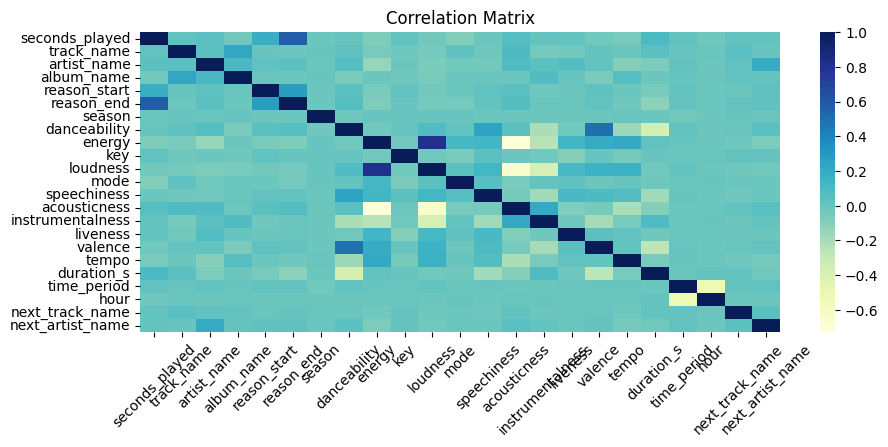

In [75]:
#now lets look at the correlation matrix of the features to pick the features that we will use to build the model

# Calculate the correlation matrix
df_audio_features_corr = df_audio_features.copy()
df_audio_features_corr = df_audio_features_corr.drop(columns=['ts', 'username', 'platform', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted', 'uri',
       'shuffle', 'skipped', 'offline_timestamp', 'incognito_mode',
       'type', 'id', 'track_href', 'analysis_url',
       'time_signature','complete_action'])
#display non numeric columns
display(df_audio_features_corr.select_dtypes(exclude=['int64', 'float64']).columns)


label_list = ['reason_start', 'reason_end', 'season', 'time_period', 'track_name', 'artist_name', 'album_name', 'next_track_name', 'next_artist_name']
label_encoders = {}
for column in label_list:
       le = LabelEncoder()
       df_audio_features_corr[column] = le.fit_transform(df_audio_features_corr[column])
       label_encoders[column] = le
corr_matrix = df_audio_features_corr.corr()



# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=False, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
plt.savefig(os.path.join('figures', f'correlation_matrix_big.png'))
plt.show()


In [76]:
#COULDNT BEAR TO THROW AYTHING AWAY
#BUT THIS PART OF THE CODE IS NOT USED IN THE PROJECT


#pick the feature that we want to predict
#we will try to predict the action(reason_end) of the user based on the features; season, time period, reason start
x_train = train_set[['season', 'time_period', 'reason_start']]
y_train = train_set['reason_end']
x_val = val_set[['season', 'time_period', 'reason_start']]
y_val = val_set['reason_end']
x_test = test_set[['season', 'time_period', 'reason_start']]
y_test = test_set['reason_end']

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters to tune and their possible values
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20,2),
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best hyperparameter values
print("Best Hyperparameters:", grid_search.best_params_)
best_parameters = grid_search.best_params_

# Evaluate the model on the validation set
val_accuracy = grid_search.best_estimator_.score(x_val, y_val)
print("Validation Accuracy with Best Hyperparameters:", val_accuracy)


# Create a DecisionTreeClassifier with the best hyperparameters
depth= best_parameters['max_depth']
split= best_parameters['min_samples_split']
print("depth:", depth)
print("split:", split)
best_dt_classifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)

# Train the model on the training set
best_dt_classifier.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = best_dt_classifier.predict(x_test)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)

Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 2}
Validation Accuracy with Best Hyperparameters: 0.6698125573469655
depth: 8
split: 2
Test Accuracy with Best Hyperparameters: 0.6684141546526867


Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 18}
Validation Accuracy with Best Hyperparameters: 0.6733516843623018
depth: 9
split: 18
Test Accuracy with Best Hyperparameters: 0.6747051114023591


<Figure size 2000x1000 with 0 Axes>

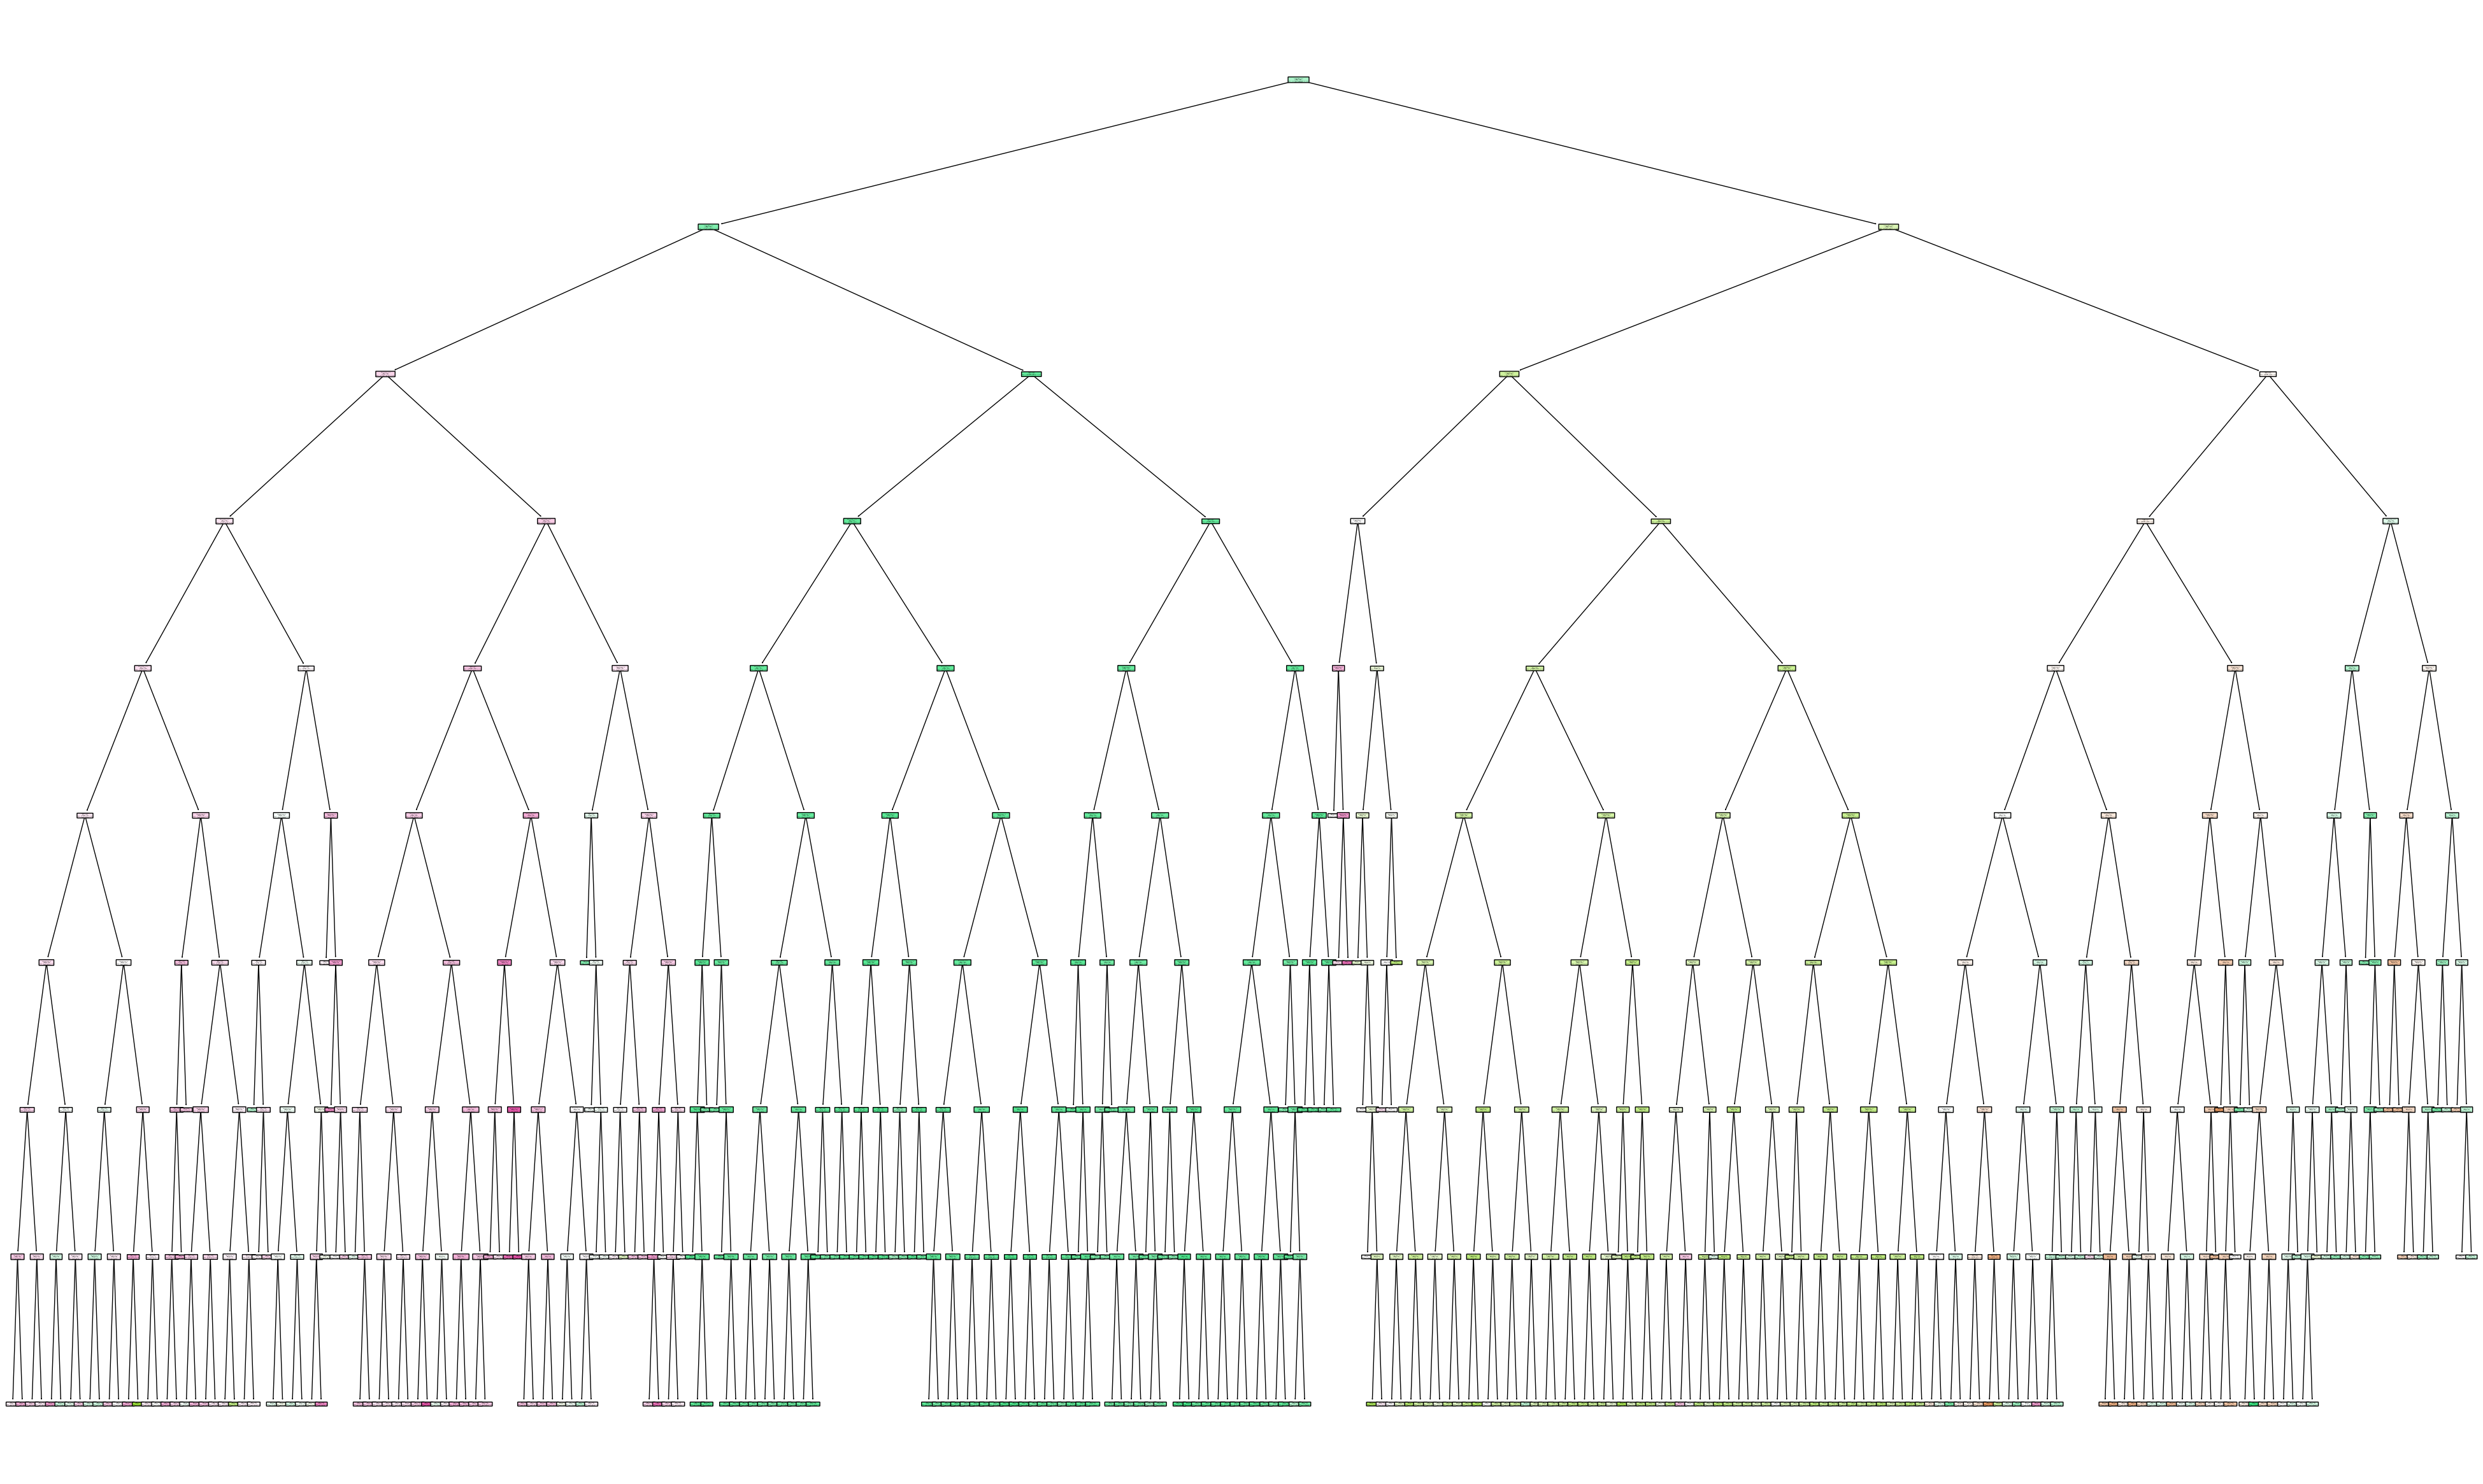

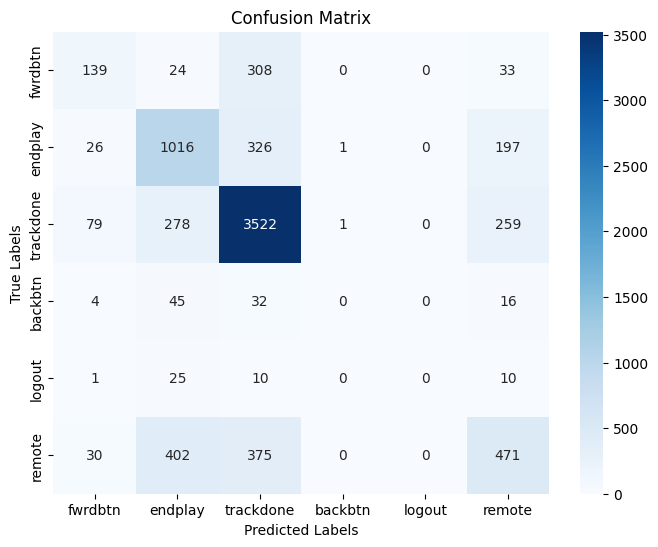

In [77]:
#new feature = day of the week
new_try = shuffle_df.copy()
new_try['day_of_week'] = new_try['ts'].dt.day_name()
new_try['day_of_week'] = new_try['day_of_week'].astype('category').cat.codes
train_set = new_try.iloc[:int(0.7*len(new_try))]
val_set = new_try.iloc[int(0.7*len(new_try)):int(0.85*len(new_try))]
test_set = new_try.iloc[int(0.85*len(new_try)):]
x_train = train_set[['season', 'time_period', 'reason_start', 'day_of_week']]   
y_train = train_set['reason_end']
x_val = val_set[['season', 'time_period', 'reason_start', 'day_of_week']]
y_val = val_set['reason_end']
x_test = test_set[['season', 'time_period', 'reason_start', 'day_of_week']]
y_test = test_set['reason_end']
dt_classifier = DecisionTreeClassifier()
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20,2),
}
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_parameters = grid_search.best_params_
val_accuracy = grid_search.best_estimator_.score(x_val, y_val)
print("Validation Accuracy with Best Hyperparameters:", val_accuracy)
depth= best_parameters['max_depth']
split= best_parameters['min_samples_split']
print("depth:", depth)
print("split:", split)
best_dt_classifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
best_dt_classifier.fit(x_train, y_train)
y_pred = best_dt_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


# Plot the trained decision tree
plt.figure(figsize=(20, 10))

class_names = ['fwrdbtn', 'endplay', 'trackdone', 'backbtn', 'logout', 'remote']
# Plot the trained decision tree
plt.figure(figsize=(50, 30))
plot_tree(best_dt_classifier, feature_names=list(x_train.columns), class_names=class_names,
          filled=True, rounded=True)
plt.savefig(os.path.join('figures', f'decision_tree_weekIncluded.png'))


#code here
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(os.path.join('figures', f'confusion_matrix_weekIncluded.png'))


reason_start
3     27950
10    10164
0      7923
14     3328
6      1343
5       154
Name: count, dtype: int64

reason_end
fwdbtn       27761
endplay      10624
trackdone     8183
backbtn       3328
logout         696
remote         270
Name: count, dtype: int64

35603

7629

7630

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2}
Validation Accuracy with Best Hyperparameters: 0.6797745445012453
depth: 5
split: 2
Test Accuracy with Best Hyperparameters: 0.6775884665792923
Test Accuracy with Best Hyperparameters: 0.6775884665792923
Precision: 0.98
Recall: 0.96
F1 Score: 0.97


<Figure size 2000x1000 with 0 Axes>

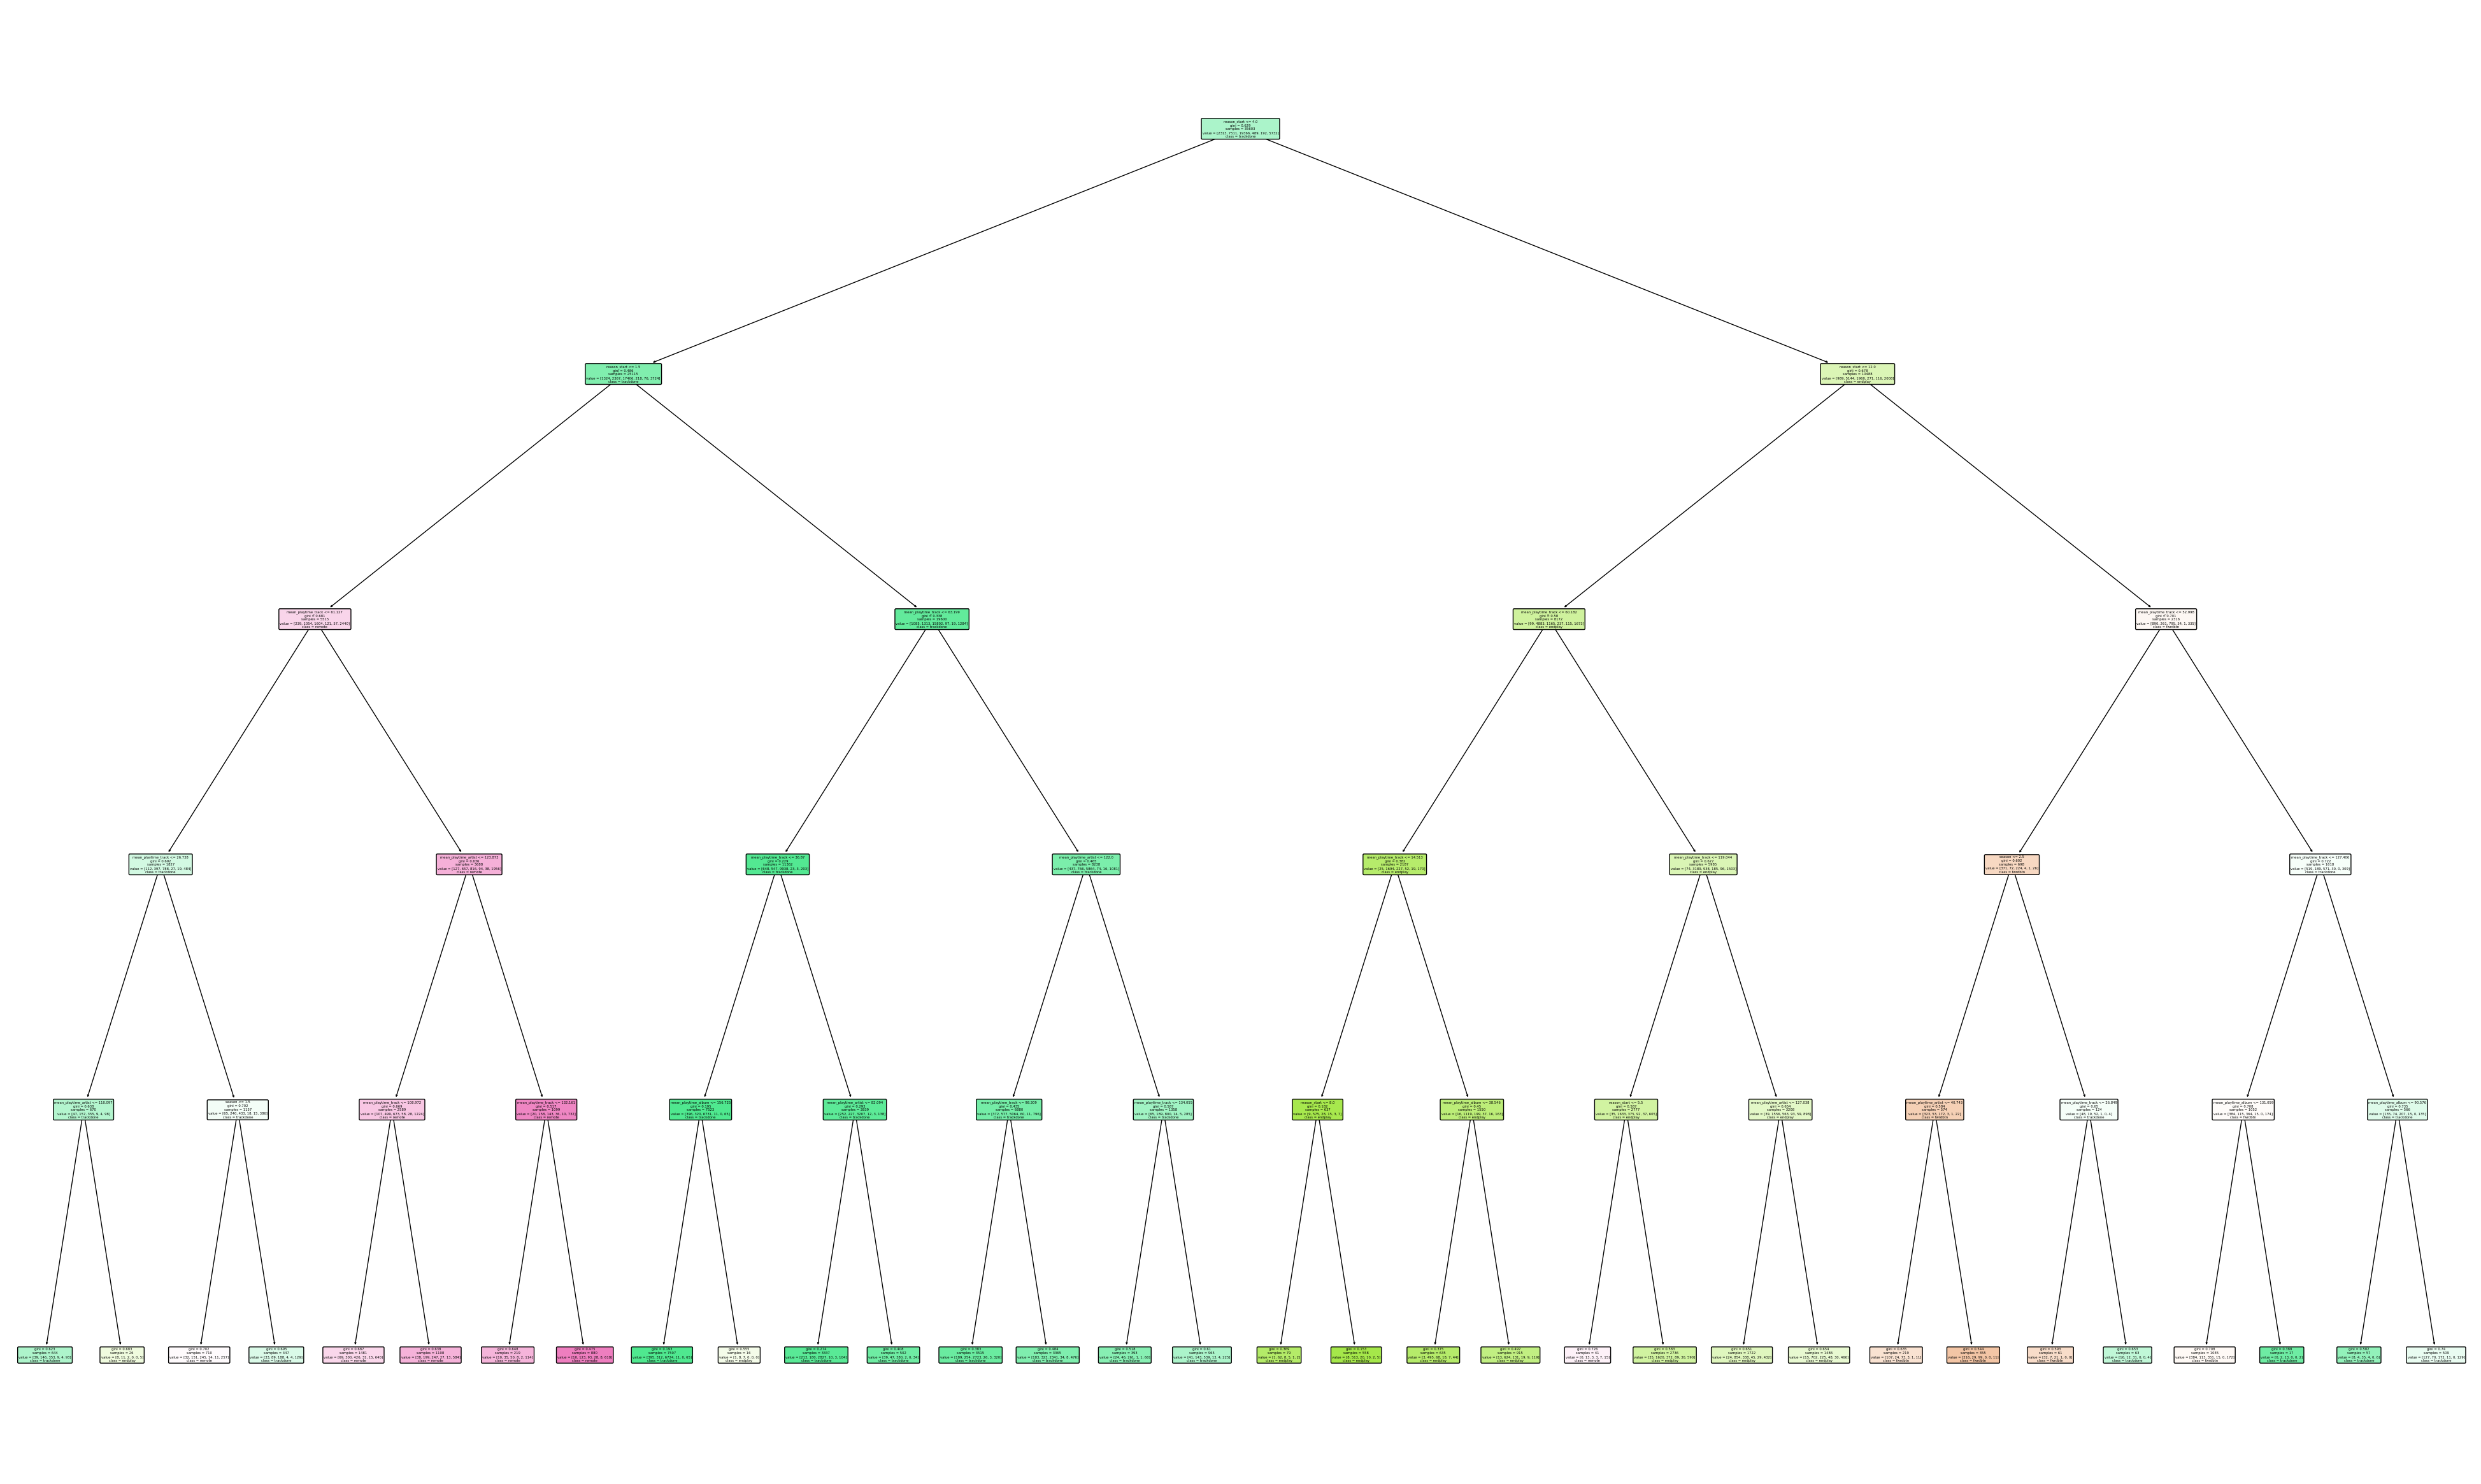

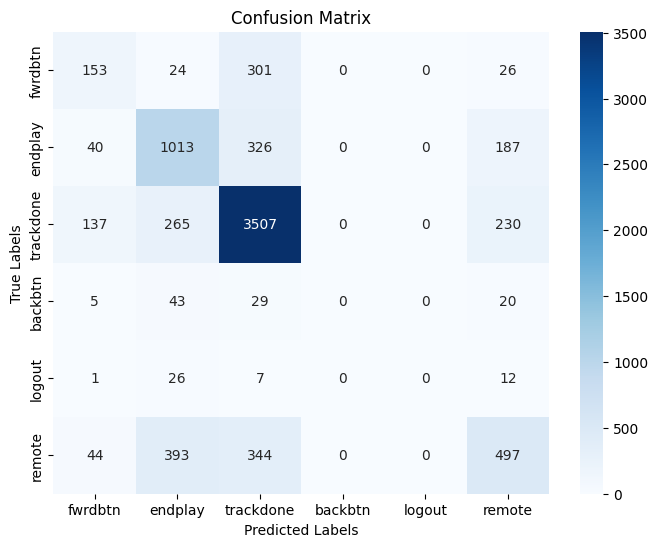

In [81]:
#New Hypothesis3, the longer i listen to a track on average, the more likely i am not to skip it
#Corolary to Hypothesis3 And if this is true, the playtime of a song should be a good feature to predict the reason_end

#now lets fid the average playtime of each song


# Group by 'artist_name' and calculate the mean playtime for each artist
track_mean_playtime = df_audio_features.groupby('track_name')['seconds_played'].mean()
artist_mean_playtime = df_audio_features.groupby('artist_name')['seconds_played'].mean()
album_mean_playtime = df_audio_features.groupby('album_name')['seconds_played'].mean()

# Create a new column 'mean_playtime_artist' by mapping the 'artist_name' to its mean playtime
df_audio_features['mean_playtime_artist'] = df_audio_features['artist_name'].map(artist_mean_playtime)
df_audio_features['mean_playtime_track'] = df_audio_features['track_name'].map(track_mean_playtime)
df_audio_features['mean_playtime_album'] = df_audio_features['album_name'].map(album_mean_playtime)



# WE will develop a desicion tree to predict the reason_end based on the features; 
#season, time_period, reason_start, seconds_playe, mean_playtime_artist, mead_playtime_track, mean_playtime_album
#we will have 3 sets of data, train, validation and test
shuffle_df = df_audio_features.sample(frac=1,random_state=4).reset_index(drop=True)


sentiment_start_map= {'fwdbtn' : 3, 'clickrow' : 10, 'trackdone' : 0, 'backbtn' : 14, 'playbtn' : 6, 'appload' : 3, 'remote' : 5}
#map it to reason start
shuffle_df['reason_start'] = shuffle_df['reason_start'].map(sentiment_start_map)

display(shuffle_df['reason_start'].value_counts())
display(shuffle_df['reason_end'].value_counts())

# Define the column list
column_list_label = ['season', 'time_period', 'reason_end']
#encode the categorical features with one hot encoding
# Create a LabelEncoder object for each categorical column
label_encoders = {}
for column in column_list_label:
    le = LabelEncoder()
    shuffle_df[column] = le.fit_transform(shuffle_df[column])
    label_encoders[column] = le

train_set = shuffle_df.iloc[:int(0.7*len(shuffle_df))]
val_set = shuffle_df.iloc[int(0.7*len(shuffle_df)):int(0.85*len(shuffle_df))]
test_set = shuffle_df.iloc[int(0.85*len(shuffle_df)):]

display(len(train_set))
display(len(val_set))
display(len(test_set))

#pick the feature that we want to predict
#we will try to predict the action(reason_end) of the user based on the features; season, time period, reason start
x_train = train_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_train = train_set['reason_end']
x_val = val_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_val = val_set['reason_end']
x_test = test_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_test = test_set['reason_end']

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters to tune and their possible values
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20,2),
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best hyperparameter values
print("Best Hyperparameters:", grid_search.best_params_)
best_parameters = grid_search.best_params_

# Evaluate the model on the validation set
val_accuracy = grid_search.best_estimator_.score(x_val, y_val)
print("Validation Accuracy with Best Hyperparameters:", val_accuracy)


# Create a DecisionTreeClassifier with the best hyperparameters
depth= best_parameters['max_depth']
split= best_parameters['min_samples_split']
print("depth:", depth)
print("split:", split)
best_dt_classifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)

# Train the model on the training set
best_dt_classifier.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = best_dt_classifier.predict(x_test)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)

best_dt_classifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
best_dt_classifier.fit(x_train, y_train)
y_pred = best_dt_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


# Plot the trained decision tree
plt.figure(figsize=(20, 10))

class_names = ['fwrdbtn', 'endplay', 'trackdone', 'backbtn', 'logout', 'remote']
# Plot the trained decision tree
plt.figure(figsize=(50, 30))
plot_tree(best_dt_classifier, feature_names=list(x_train.columns), class_names=class_names,
          filled=True, rounded=True)
plt.savefig(os.path.join('figures', f'decision_tree_weekIncluded.png'))


#code here
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(os.path.join('figures', f'confusion_matrix_weekIncluded.png'))

def calculate_metrics(conf_matrix):
    # Extracting values from confusion matrix
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    # Calculating precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Calculating recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculating F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

conf_matrix_np = np.array(conf_matrix)

precision, recall, f1_score = calculate_metrics(conf_matrix_np)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')




In [83]:
'''failed attempt to do hypothesses testing
# Assuming conf_matrix is your confusion matrix
observed = conf_matrix
chi2, p, _, _ = chi2_contingency(observed)

# Print the p-value
print(f'P-Value (Chi-squared Test): {p}')
'''


ValueError: The internally computed table of expected frequencies has a zero element at (0, 3).

reason_start
3     27950
10    10164
0      7923
14     3328
6      1343
5       154
Name: count, dtype: int64

skip
1    31359
0    19503
Name: count, dtype: int64

35603

7629

7630

Best Hyperparameters: {'max_depth': 4, 'min_samples_split': 2}
Validation Accuracy with Best Hyperparameters: 0.8212085463363481
depth: 4
split: 2
Test Accuracy with Best Hyperparameters: 0.8195281782437746


<Figure size 2000x1000 with 0 Axes>

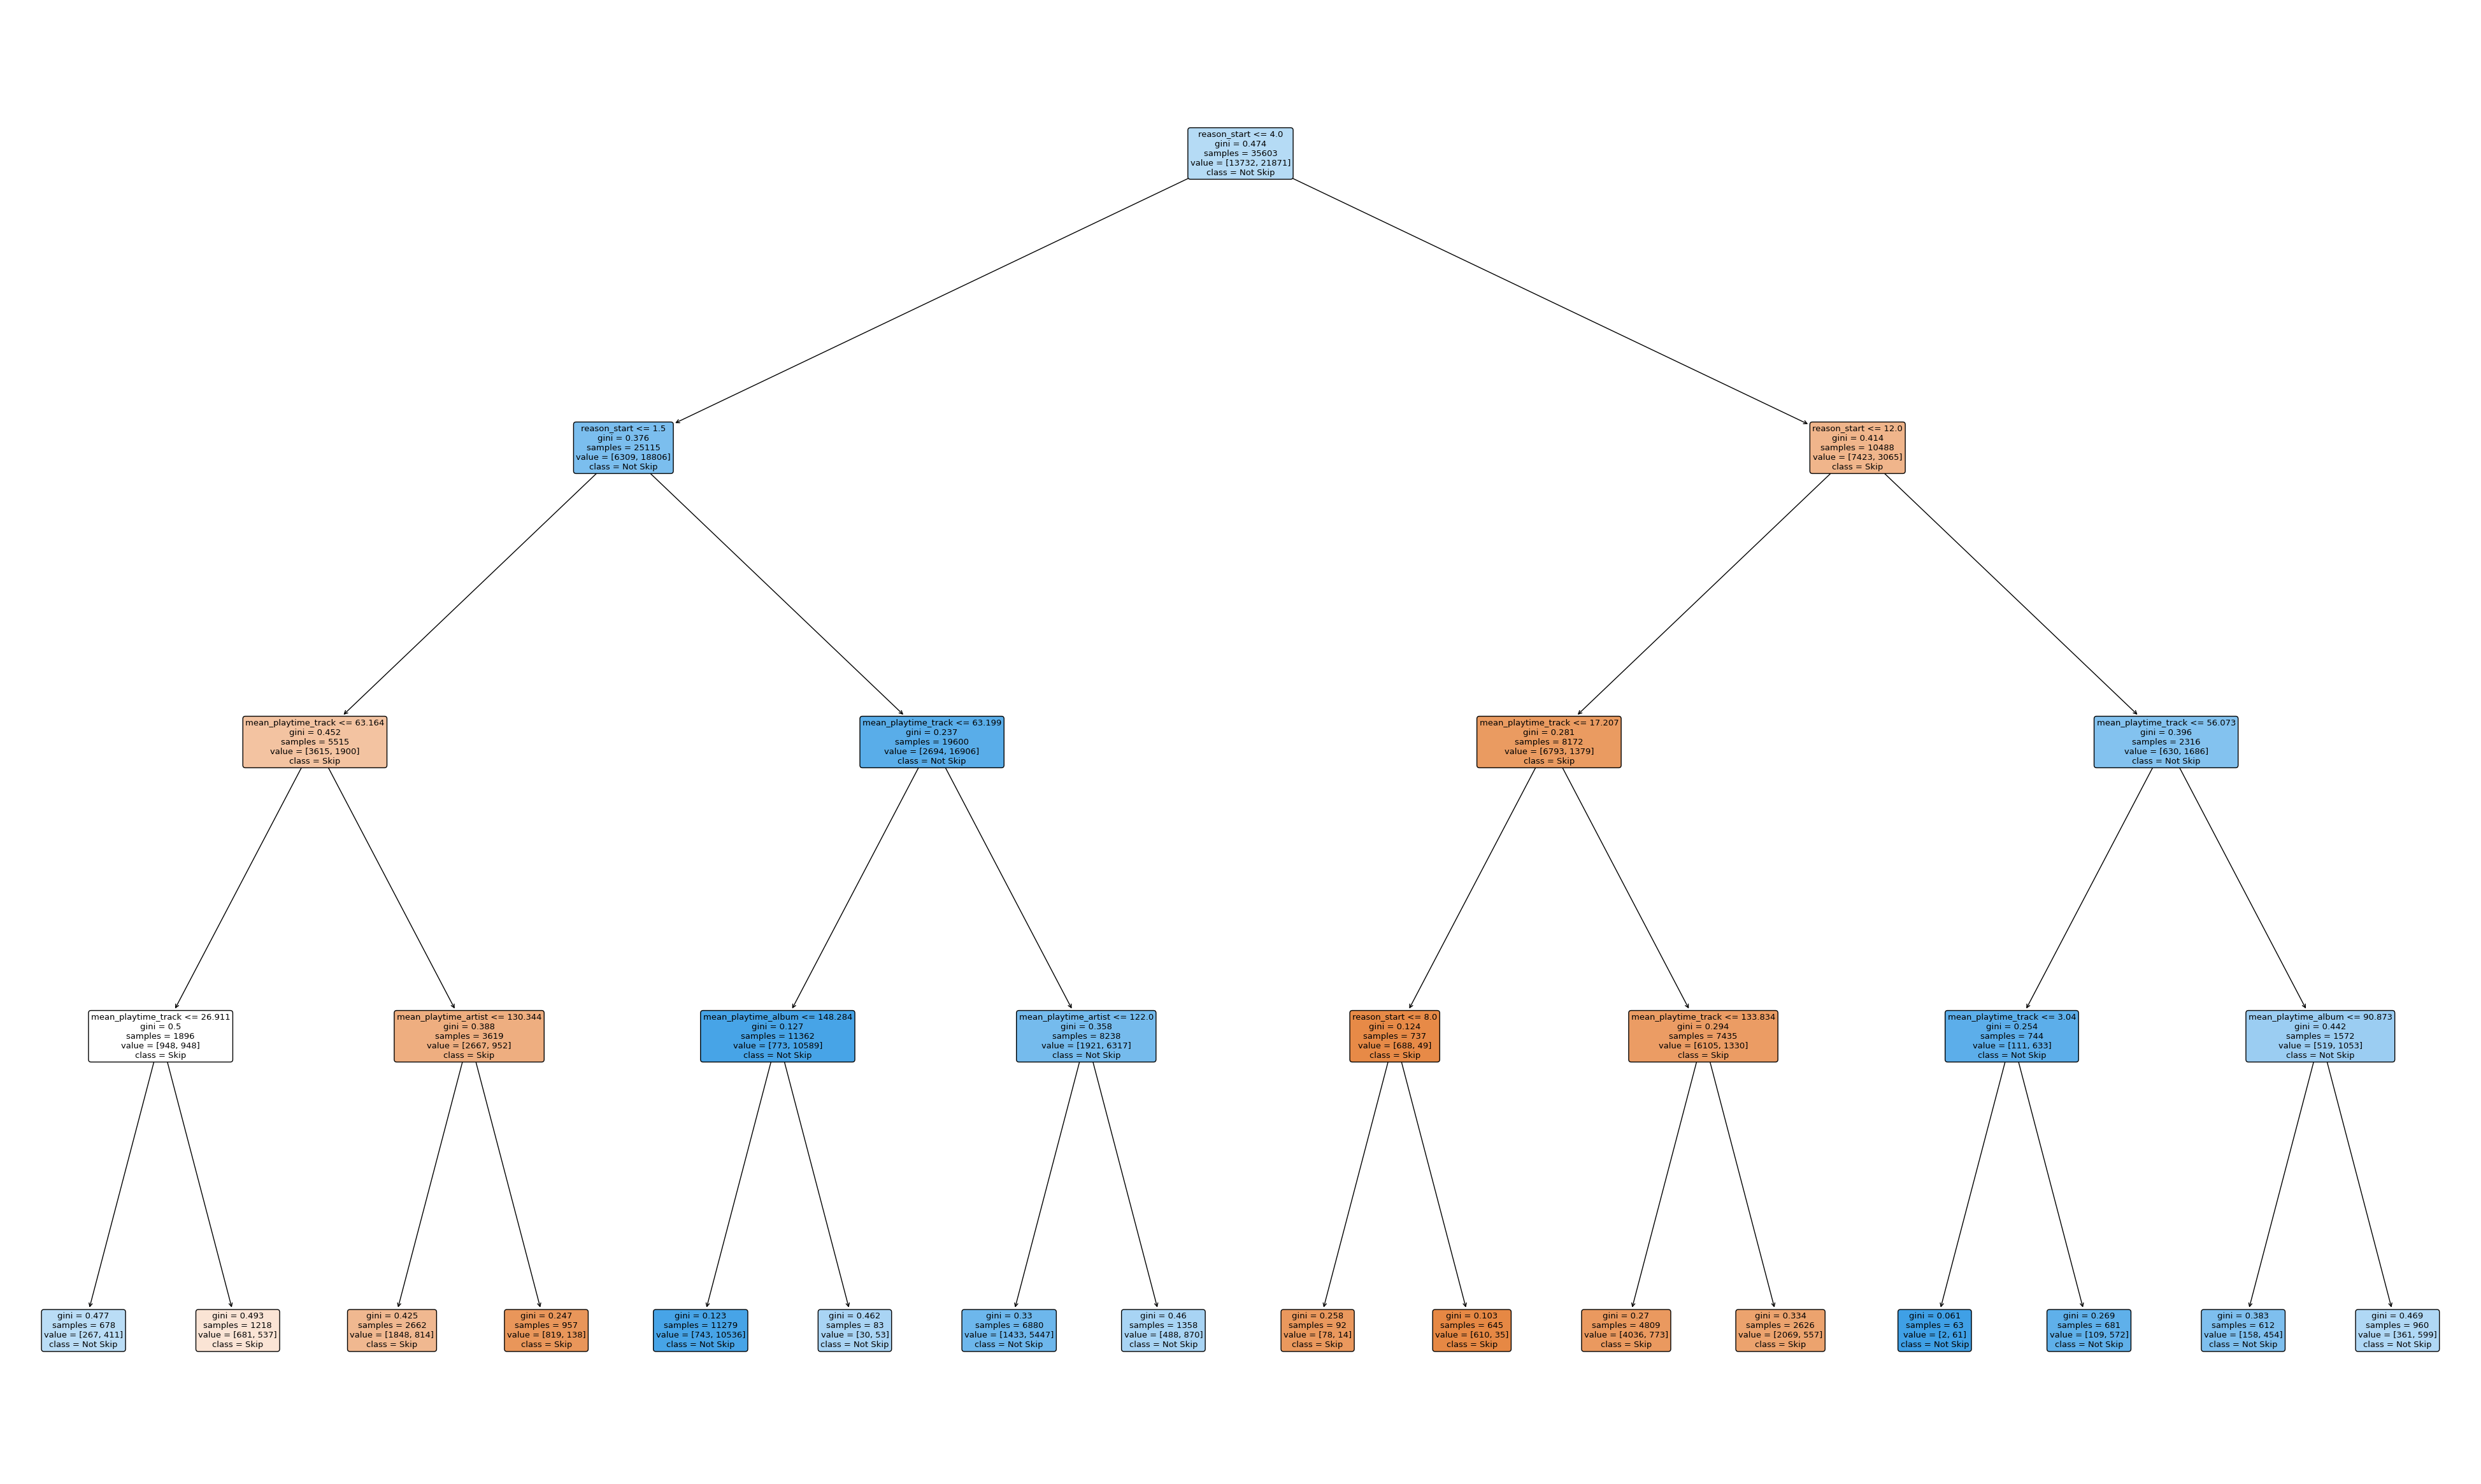

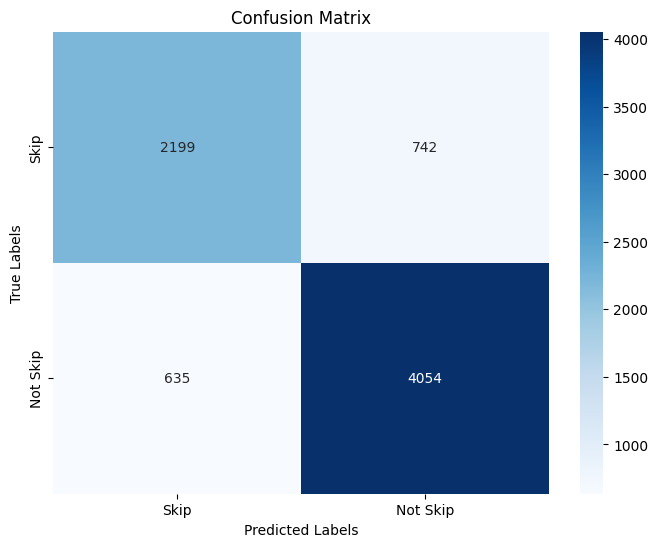

In [79]:
# Hypothesis 4: A retought on hypothesis 3, the longer i listen to a track on average, the more likely i am not to skip it
#but this time reason end and reason start are binary features, 1 for skip, 0 for not skip

#a new feature, skip, 1 for skip, 0 for not skip
hypothesis4 = df_audio_features.copy()

hypothesis4['skip'] = 33
hypothesis4.loc[hypothesis4['reason_end'] == 'fwdbtn', 'skip'] = 1
hypothesis4.loc[hypothesis4['reason_end'] == 'backbtn', 'skip'] = 1 
hypothesis4.loc[hypothesis4['reason_end'] == 'remote', 'skip'] = 1
hypothesis4.loc[hypothesis4['reason_end'] == 'trackdone', 'skip'] = 0
hypothesis4.loc[hypothesis4['reason_end'] == 'endplay', 'skip'] = 0
hypothesis4.loc[hypothesis4['reason_end'] == 'logout', 'skip'] = 0
#drop 33 
hypothesis4 = hypothesis4[hypothesis4['skip'] != 33]


# Group by 'artist_name' and calculate the mean playtime for each artist
track_mean_playtime = hypothesis4.groupby('track_name')['seconds_played'].mean()
artist_mean_playtime = hypothesis4.groupby('artist_name')['seconds_played'].mean()
album_mean_playtime = hypothesis4.groupby('album_name')['seconds_played'].mean()

# Create a new column 'mean_playtime_artist' by mapping the 'artist_name' to its mean playtime
hypothesis4['mean_playtime_artist'] = hypothesis4['artist_name'].map(artist_mean_playtime)
hypothesis4['mean_playtime_track'] = hypothesis4['track_name'].map(track_mean_playtime)
hypothesis4['mean_playtime_album'] = hypothesis4['album_name'].map(album_mean_playtime)


#we will have 3 sets of data, train, validation and test
shuffle_df = hypothesis4.sample(frac=1,random_state=4).reset_index(drop=True)


sentiment_start_map= {'fwdbtn' : 3, 'clickrow' : 10, 'trackdone' : 0, 'backbtn' : 14, 'playbtn' : 6, 'appload' : 3, 'remote' : 5}
#map it to reason start
shuffle_df['reason_start'] = shuffle_df['reason_start'].map(sentiment_start_map)

display(shuffle_df['reason_start'].value_counts())
display(shuffle_df['skip'].value_counts())

# Define the column list
column_list_label = ['season', 'time_period', 'skip']
#encode the categorical features with one hot encoding
# Create a LabelEncoder object for each categorical column
label_encoders = {}
for column in column_list_label:
    le = LabelEncoder()
    shuffle_df[column] = le.fit_transform(shuffle_df[column])
    label_encoders[column] = le

train_set = shuffle_df.iloc[:int(0.7*len(shuffle_df))]
val_set = shuffle_df.iloc[int(0.7*len(shuffle_df)):int(0.85*len(shuffle_df))]
test_set = shuffle_df.iloc[int(0.85*len(shuffle_df)):]
display(len(train_set))
display(len(val_set))
display(len(test_set))

#pick the feature that we want to predict
#we will try to predict the action(reason_end) of the user based on the features; season, time period, reason start
x_train = train_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_train = train_set['skip']
x_val = val_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_val = val_set['skip']
x_test = test_set[['season', 'time_period', 'reason_start', 'mean_playtime_artist', 'mean_playtime_track', 'mean_playtime_album']]
y_test = test_set['skip']

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters to tune and their possible values
param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20,2),
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best hyperparameter values
print("Best Hyperparameters:", grid_search.best_params_)
best_parameters = grid_search.best_params_

# Evaluate the model on the validation set
val_accuracy = grid_search.best_estimator_.score(x_val, y_val)
print("Validation Accuracy with Best Hyperparameters:", val_accuracy)


# Create a DecisionTreeClassifier with the best hyperparameters
depth= best_parameters['max_depth']
split= best_parameters['min_samples_split']
print("depth:", depth)
print("split:", split)

best_dt_classifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)

# Train the model on the training set
best_dt_classifier.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = best_dt_classifier.predict(x_test)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


# Plot the trained decision tree
plt.figure(figsize=(20, 10))

class_names = ['Skip', 'Not Skip']
# Plot the trained decision tree
plt.figure(figsize=(50, 30))
plot_tree(best_dt_classifier, feature_names=list(x_train.columns), class_names=class_names,
          filled=True, rounded=True)
plt.savefig(os.path.join('figures', f'decision_tree_weekIncluded.png'))


#code here
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(os.path.join('figures', f'confusion_matrix_binary.png'))


